In [41]:
# remove negative values and zeros
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
from memory_management import clear_memory
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs
from grid_search import runGrid
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter
import os

In [42]:
from sklearn.metrics import mean_absolute_error

def main_loop_with_stratified_cv(
    x_features, y_target, model_algorithm='xgboost', n_splits=5, error_percentile=80
):
    """
    Main loop to perform stratified cross-validation on continuous data with error tracking, plus final test set evaluation.
    
    Parameters:
    - x_features: Feature matrix.
    - y_target: Target vector (continuous).
    - model_algorithm: String, specifying the algorithm for runGrid.
    - n_splits: Number of folds for cross-validation.
    - error_percentile: Percentile threshold for identifying high-error data points.
    
    Returns:
    - x_test_scaled: Scaled test features.
    - y_test: Test target values.
    - test_predictions: Predictions for the test set.
    - scaler: Scaler used for data preprocessing.
    - difficult_points: High-error data points.
    - best_model: Trained model with best hyperparameters.
    - test_indices: Indices of test data in the original dataset.
    """

    # Keep track of the indices
    original_indices = x_features.index
    num_bins = 10  # Adjust based on data size; smaller datasets may need fewer bins
    y_binned = pd.qcut(y_target.iloc[:, 0].rank(method="first"), num_bins, labels=False)

    # Perform train-test split, keeping track of indices
    x_train_val, x_test, y_train_val, y_test, train_val_indices, test_indices = train_test_split(
        x_features, y_target, original_indices, test_size=0.2, stratify=y_binned, random_state=24
    )
    
    # Run grid search to find the best hyperparameters on the full training set
    best_model = runGrid(model_algorithm, x_train_val, y_train_val, maximum=-np.inf, metric='r2')

    # Lists to hold metrics across random states
    all_rmse = []
    all_r2 = []
    all_mae = []
    
    # Loop over random states for cross-validation
    for random_state in range(30):

        # Convert y_train_val to bins for StratifiedKFold compatibility
        y_train_binned = pd.qcut(y_train_val.iloc[:, 0].rank(method="first"), num_bins, labels=False)

        # Initialize StratifiedKFold with the current random state for cross-validation
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        # Lists to hold metrics for each fold within this random state
        rmse_list = []
        r2_list = []
        mae_list = []
        error_tracker = {}

        # Cross-validation loop
        for _ , (train_index, val_index) in enumerate(kf.split(x_train_val, y_train_binned)):  # Use y_train_binned for stratification

            # Create training and validation sets for the current fold
            x_train, x_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index]
            y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

            # Scale the data
            scaler = StandardScaler()
            x_train_scaled = scaler.fit_transform(x_train)
            x_val_scaled = scaler.transform(x_val)

            # Fit the model on the training data for each fold
            if model_algorithm == 'xgboost':
                model_clone = clone(best_model)
                model_clone.fit(x_train_scaled, y_train, eval_set=[(x_val_scaled, y_val)], verbose=False)
                predictions = model_clone.predict(x_val_scaled)
            else:
                best_model.fit(x_train_scaled, y_train)
                predictions = best_model.predict(x_val_scaled)

            predictions = predictions.flatten()
            validation_rmse = np.sqrt(mean_squared_error(y_val, predictions))
            validation_r2 = r2_score(y_val, predictions)
            validation_mae = mean_absolute_error(y_val, predictions)

            # Track high-error data points
            residuals = abs(predictions - y_val.values.flatten())
            for idx, error in zip(y_val.index, residuals):
                if error > np.percentile(residuals, error_percentile):
                    if idx not in error_tracker:
                        error_tracker[idx] = []
                    error_tracker[idx].append(error)

            # Append metrics for this fold
            rmse_list.append(validation_rmse)
            r2_list.append(validation_r2)
            mae_list.append(validation_mae)
            # Clear memory after each fold
            del x_train, x_val, y_train, y_val, x_train_scaled, x_val_scaled
            if model_algorithm == 'xgboost':
                del model_clone
            clear_memory()
        # Aggregate metrics for this random state
        all_rmse.append(np.mean(rmse_list))
        all_r2.append(np.mean(r2_list))
        all_mae.append(np.mean(mae_list))
        # Clear memory after each random state iteration
        del y_train_binned, rmse_list, r2_list, mae_list
        clear_memory()
    # Calculate average and standard deviation of metrics across random states
    avg_rmse = np.mean(all_rmse)
    std_rmse = np.std(all_rmse)
    avg_r2 = np.mean(all_r2)
    std_r2 = np.std(all_r2)
    avg_mae = np.mean(all_mae)
    std_mae = np.std(all_mae)

    # Test set evaluation using the best model
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_val)
    x_test_scaled = scaler.transform(x_test)
    
    # Further split x_train_val into a training and validation set for early stopping
    x_train_main, x_val_final, y_train_main, y_val_final = train_test_split(
        x_train_scaled, y_train_val, test_size=0.1, random_state=22  # Use a small portion for validation
    )
    if model_algorithm == 'xgboost':
        best_model.fit(
            x_train_main, y_train_main,
            eval_set=[(x_val_final, y_val_final)],  # Provide validation set for early stopping
            verbose=False
        )
    else:
        best_model.fit(x_train_scaled, y_train_val)
    test_predictions = best_model.predict(x_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    # Output high-error data points with their average errors
    difficult_points = {idx: np.mean(errors) for idx, errors in error_tracker.items()}
    print("\nHigh-error data points:")
    for idx, avg_error in difficult_points.items():
        print(f"Data Point Index: {idx}, Average Error: {avg_error}")

    # Display cross-validation metrics summary and test performance
    print("-----------------Cross-Validation Results Summary------------")
    print(f"Algorithm: {model_algorithm}")
    print(f"Average RMSE: {avg_rmse}, Standard Deviation RMSE: {std_rmse}")
    print(f"Average MAE: {avg_mae}, Standard Deviation MAE: {std_mae}")
    print(f"Average R²: {avg_r2}, Standard Deviation R²: {std_r2}")
    print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}")

    return x_test_scaled, y_test, test_predictions, scaler, test_indices, difficult_points, best_model



In [43]:
def combine_and_rank_feature_importance(rf_model, xgb_model, x_features, top_n=10):
    """
    Combines and ranks feature importance from XGBoost and Random Forest models after normalizing.

    Parameters:
    - rf_model: Trained Random Forest model.
    - xgb_model: Trained XGBoost model.
    - feature_names: List of feature names (columns) used in the models.
    - top_n: Number of top features to select (default is 10).
    
    Returns:
    - A list of top features based on combined importance scores.
    """

    # Get feature importance from both models
    xgb_importance = xgb_model.feature_importances_
    rf_importance = rf_model.feature_importances_
    feature_names=x_features.columns
    # Stack feature importances for normalization
    importances = pd.DataFrame({
        'Feature': feature_names,
        'XGBoost_Importance': xgb_importance,
        'RandomForest_Importance': rf_importance,
    })

    # Normalize the importance scores for both models
    scaler = MinMaxScaler()
    importances[['XGBoost_Importance', 'RandomForest_Importance']] = scaler.fit_transform(
        importances[['XGBoost_Importance', 'RandomForest_Importance']]
    )

    # Calculate combined importance
    importances['Combined_Importance'] = (importances['XGBoost_Importance'] + importances['RandomForest_Importance']) / 2

    # Sort by combined importance and select the top N features
    top_features = importances.sort_values(by='Combined_Importance', ascending=False).head(top_n)

    # Display the result
    print(f"Top {top_n} combined important features:")
    print(top_features[['Feature', 'Combined_Importance']])

    return top_features['Feature'].tolist()

# LUMO Only

In [133]:
# PCE prediction with LUMO (base estimation) 
df_LUMO_only=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
# Initial split to set aside a test set
x_features = pd.DataFrame(df_LUMO_only['LUMO'])
y_target = pd.DataFrame(df_LUMO_only['PCE'])
x_test_LUMO_scaled_xgboost, y_test_LUMO_xgboost, test_predictions_LUMO_xgboost, scaler_LUMO_xgboost, test_indices_LUMO_xgboost, difficult_points_LUMO_xgboost, best_model_xgboost_LUMO_xgboost=main_loop_with_stratified_cv(x_features,y_target,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_scaled_RF, y_test_LUMO_RF, test_predictions_LUMO_RF, scaler_LUMO_RF, test_indices_LUMO_RF, difficult_points_LUMO_RF, best_model_xgboost_LUMO_RF=main_loop_with_stratified_cv(x_features,y_target,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6979467391967773
Overfitting parameters - Training R²: 0.7618663549423218
Best R² Score: 0.7867246747016907
Overfitting parameters - Training R²: 0.8872334361076355
Best R² Score: 0.7909331440925598
Overfitting parameters - Training R²: 0.8839131712913513
Best R² Score: 0.7918917417526246
Overfitting parameters - Training R²: 0.8821475028991699
Best R² Score: 0.793677830696106
Overfitting parameters - Training R²: 0.8690645217895507
Best R² Score: 0.7940155744552613
Overfitting parameters - Training R²: 0.8653321266174316
Best R² Score: 0.7974473834037781
Overfitting parameters - Training R²: 0.9087733387947082
Best R² Score: 0.8093951344490051
Overfitting parameters - Training R²: 0.9072728991508484
Best R² Score: 0.811040461063385
Overfitting parameters - Training R²: 0.9087801337242126
Best R² Score: 0.8129569172859192
Overfitting parameters - Training R²: 0.9044393301010132
Best R² Score: 0.8151238203048706
Overfitting parameters - Training R²: 0.9036522030830383
B

# LUMO + HOMO

In [153]:
df_HOMO_LUMO=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
x_features_HOMO_LUMO = df_HOMO_LUMO[['LUMO','HOMO']]
y_target = df_HOMO_LUMO['PCE'].to_frame()
x_test_LUMO_HOMO_scaled_xgboost, y_test_LUMO_HOMO_xgboost, test_predictions_LUMO_HOMO_xgboost, scaler_LUMO_HOMO_xgboost, test_indices_LUMO_HOMO_xgboost, difficult_points_LUMO_HOMO_xgboost, best_model_xgboost_LUMO_HOMO_xgboost=main_loop_with_stratified_cv(x_features_HOMO_LUMO,y_target,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_HOMO_scaled_RF, y_test_LUMO_HOMO_RF, test_predictions_LUMO_HOMO_RF, scaler_LUMO_HOMO_RF, test_indices_LUMO_HOMO_RF, difficult_points_LUMO_HOMO_RF, best_model_xgboost_LUMO_HOMO_RF=main_loop_with_stratified_cv(x_features_HOMO_LUMO,y_target,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.5638483166694641
Overfitting parameters - Training R²: 0.6250146985054016
Best R² Score: 0.7209920287132263
Overfitting parameters - Training R²: 0.811604118347168
Best R² Score: 0.8021374106407165
Overfitting parameters - Training R²: 0.934195625782013
Best R² Score: 0.8096522450447082
Overfitting parameters - Training R²: 0.9435266852378845
Best R² Score: 0.8127611756324769
Overfitting parameters - Training R²: 0.945200788974762
Best R² Score: 0.8341800332069397
Overfitting parameters - Training R²: 0.9378057241439819
Best R² Score: 0.8355613827705384
Overfitting parameters - Training R²: 0.9365190267562866
Best R² Score: 0.8371965885162354
Overfitting parameters - Training R²: 0.9298768997192383
Best R² Score: 0.8378680348396301
Overfitting parameters - Training R²: 0.9279708385467529
Best R² Score: 0.8384546399116516
Overfitting parameters - Training R²: 0.9283175706863404
Best R² Score: 0.8405847191810608
Overfitting parameters - Training R²: 0.9307151913642884
Be

# MACCS + LUMO

In [10]:
df_maccs=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/MACCS_linear_dependent_removed.csv')
print(df_maccs.columns)
x_LUMO_maccs = df_maccs.drop(columns='PCE')
y=df_maccs['PCE'].to_frame()
x_test_LUMO_maccs_xgboost, y_test_LUMO_maccs_xgboost, test_predictions_LUMO_maccs_xgboost, scaler_LUMO_maccs_xgboost, test_indices_LUMO_maccs_xgboost, difficult_points_LUMO_maccs_xgboost, best_model_xgboost_LUMO_maccs_xgboost=main_loop_with_stratified_cv(x_LUMO_maccs,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_maccs_RF, y_test_LUMO_maccs_RF, test_predictions_LUMO_maccs_RF, scaler_LUMO_maccs_RF, test_indices_LUMO_maccs_RF, difficult_points_LUMO_maccs_RF, best_model_RF_LUMO_maccs=main_loop_with_stratified_cv(x_LUMO_maccs,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Index(['PCE', 'LUMO', 'MACCSFP20', 'MACCSFP26', 'MACCSFP33', 'MACCSFP41',
       'MACCSFP42', 'MACCSFP47', 'MACCSFP50', 'MACCSFP62', 'MACCSFP65',
       'MACCSFP66', 'MACCSFP72', 'MACCSFP74', 'MACCSFP75', 'MACCSFP80',
       'MACCSFP81', 'MACCSFP85', 'MACCSFP89', 'MACCSFP92', 'MACCSFP93',
       'MACCSFP97', 'MACCSFP98', 'MACCSFP105', 'MACCSFP113', 'MACCSFP120',
       'MACCSFP121', 'MACCSFP123', 'MACCSFP127', 'MACCSFP133', 'MACCSFP140',
       'MACCSFP141', 'MACCSFP142', 'MACCSFP144', 'MACCSFP145', 'MACCSFP149',
       'MACCSFP150', 'MACCSFP154', 'MACCSFP156', 'MACCSFP157', 'MACCSFP159',
       'MACCSFP160', 'MACCSFP163', 'MACCSFP164'],
      dtype='object')
Best R² Score: 0.6664831519126893
Overfitting parameters - Training R²: 0.7362371683120728
Best R² Score: 0.7842370510101319
Overfitting parameters - Training R²: 0.8858951210975647
Best R² Score: 0.7870933651924134
Overfitting parameters - Training R²: 0.8805981040000915
Best R² Score: 0.7877472996711731
Overfitting parameters - 

In [11]:
top_50_LUMO_maccs=combine_and_rank_feature_importance(best_model_xgboost_LUMO_maccs_xgboost,best_model_RF_LUMO_maccs,x_LUMO_maccs ,50)
top_30_LUMO_maccs=combine_and_rank_feature_importance(best_model_xgboost_LUMO_maccs_xgboost,best_model_RF_LUMO_maccs,x_LUMO_maccs ,30)
top_10_LUMO_maccs=combine_and_rank_feature_importance(best_model_xgboost_LUMO_maccs_xgboost,best_model_RF_LUMO_maccs,x_LUMO_maccs ,10)
top_5_LUMO_maccs=combine_and_rank_feature_importance(best_model_xgboost_LUMO_maccs_xgboost,best_model_RF_LUMO_maccs,x_LUMO_maccs ,5)

Top 50 combined important features:
       Feature  Combined_Importance
0         LUMO             0.798485
31  MACCSFP142             0.587571
4    MACCSFP41             0.402067
18   MACCSFP92             0.251315
6    MACCSFP47             0.227076
7    MACCSFP50             0.167429
42  MACCSFP164             0.125386
33  MACCSFP145             0.122273
21   MACCSFP98             0.092094
30  MACCSFP141             0.091860
37  MACCSFP156             0.081082
23  MACCSFP113             0.073826
3    MACCSFP33             0.071469
14   MACCSFP80             0.069742
15   MACCSFP81             0.063538
20   MACCSFP97             0.060696
2    MACCSFP26             0.059657
24  MACCSFP120             0.055863
22  MACCSFP105             0.045821
41  MACCSFP163             0.045399
9    MACCSFP65             0.044238
11   MACCSFP72             0.042504
13   MACCSFP75             0.039625
28  MACCSFP133             0.038064
26  MACCSFP123             0.034608
36  MACCSFP154             0

# LUMO+ MACCS50 

In [12]:
x_test_LUMO_maccs_xgboost_50, y_test_LUMO_maccs_xgboost_50, test_predictions_LUMO_maccs_xgboost_50, scaler_LUMO_maccs_xgboost_50, test_indices_LUMO_maccs_xgboost_50, difficult_points_LUMO_maccs_xgboost_50, best_model_xgboost_LUMO_maccs_50=main_loop_with_stratified_cv(x_LUMO_maccs[top_50_LUMO_maccs],y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_maccs_RF_50, y_test_LUMO_maccs_RF_50, test_predictions_LUMO_maccs_RF_50, scaler_LUMO_maccs_RF_50, test_indices_LUMO_maccs_RF_50, difficult_points_LUMO_maccs_RF_50, best_model_RF_LUMO_maccs_50=main_loop_with_stratified_cv(x_LUMO_maccs[top_50_LUMO_maccs],y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6648008227348328
Overfitting parameters - Training R²: 0.7361508846282959
Best R² Score: 0.7805606842041015
Overfitting parameters - Training R²: 0.885204529762268
Best R² Score: 0.7841317534446717
Overfitting parameters - Training R²: 0.8798584818840027
Best R² Score: 0.7849769115447998
Overfitting parameters - Training R²: 0.8777523636817932
Best R² Score: 0.788150680065155
Overfitting parameters - Training R²: 0.9017389178276062
Best R² Score: 0.7893410921096802
Overfitting parameters - Training R²: 0.8985185980796814
Best R² Score: 0.7918556571006775
Overfitting parameters - Training R²: 0.876819109916687
Best R² Score: 0.7963164210319519
Overfitting parameters - Training R²: 0.9352815985679627
Best R² Score: 0.8009060859680176
Overfitting parameters - Training R²: 0.9340157389640809
Best R² Score: 0.806912875175476
Overfitting parameters - Training R²: 0.9346012115478516
Best R² Score: 0.8166989088058472
Overfitting parameters - Training R²: 0.9314125418663025
Bes

# LUMO+ MACCS30

In [13]:
x_test_LUMO_maccs_xgboost_30, y_test_LUMO_maccs_xgboost_30, test_predictions_LUMO_maccs_xgboost_30, scaler_LUMO_maccs_xgboost_30, test_indices_LUMO_maccs_xgboost_50, difficult_points_LUMO_maccs_xgboost_30, best_model_xgboost_LUMO_maccs_30=main_loop_with_stratified_cv(x_LUMO_maccs[top_30_LUMO_maccs],y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_maccs_RF_30, y_test_LUMO_maccs_RF_30, test_predictions_LUMO_maccs_RF_30, scaler_LUMO_maccs_RF_30, test_indices_LUMO_maccs_RF_30, difficult_points_LUMO_maccs_RF_30, best_model_RF_LUMO_maccs_30=main_loop_with_stratified_cv(x_LUMO_maccs[top_30_LUMO_maccs],y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6794259786605835
Overfitting parameters - Training R²: 0.7477752327919006
Best R² Score: 0.7874090671539307
Overfitting parameters - Training R²: 0.8892487287521362
Best R² Score: 0.7900669574737549
Overfitting parameters - Training R²: 0.8841768503189087
Best R² Score: 0.7904494047164917
Overfitting parameters - Training R²: 0.8821291327476501
Best R² Score: 0.7906150341033935
Overfitting parameters - Training R²: 0.8661234617233277
Best R² Score: 0.7907970666885376
Overfitting parameters - Training R²: 0.9001462817192077
Best R² Score: 0.7933584570884704
Overfitting parameters - Training R²: 0.8779301643371582
Best R² Score: 0.8040048122406006
Overfitting parameters - Training R²: 0.9295585870742797
Best R² Score: 0.8099954724311829
Overfitting parameters - Training R²: 0.93974529504776
Best R² Score: 0.8231884360313415
Overfitting parameters - Training R²: 0.9350529789924622
Best R² Score: 0.8262975096702576
Overfitting parameters - Training R²: 0.9349263191223145
B

# LUMO+ MACCS10

In [48]:
x_test_LUMO_maccs_xgboost_10, y_test_LUMO_maccs_xgboost_10, test_predictions_LUMO_maccs_xgboost_10, scaler_LUMO_maccs_xgboost_10, test_indices_LUMO_maccs_xgboost_10, difficult_points_LUMO_maccs_xgboost_10, best_model_xgboost_LUMO_maccs_10=main_loop_with_stratified_cv(x_LUMO_maccs[top_10_LUMO_maccs],y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_maccs_RF_10, y_test_LUMO_maccs_RF_10, test_predictions_LUMO_maccs_RF_10, scaler_LUMO_maccs_RF_10, test_indices_LUMO_maccs_RF_10, difficult_points_LUMO_maccs_RF_10, best_model_RF_LUMO_maccs_10=main_loop_with_stratified_cv(x_LUMO_maccs[top_10_LUMO_maccs],y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6752485275268555
Overfitting parameters - Training R²: 0.7368739366531372
Best R² Score: 0.779035770893097
Overfitting parameters - Training R²: 0.8740993738174438
Best R² Score: 0.7828430891036987
Overfitting parameters - Training R²: 0.8697254538536072
Best R² Score: 0.7828696727752685
Overfitting parameters - Training R²: 0.8679830670356751
Best R² Score: 0.7857510089874268
Overfitting parameters - Training R²: 0.8486380815505982
Best R² Score: 0.7874807715415955
Overfitting parameters - Training R²: 0.9070783734321595
Best R² Score: 0.7922016143798828
Overfitting parameters - Training R²: 0.9117478013038636
Best R² Score: 0.7960191369056702
Overfitting parameters - Training R²: 0.9132055521011353
Best R² Score: 0.8193069577217102
Overfitting parameters - Training R²: 0.9120212435722351
Best R² Score: 0.8220140695571899
Overfitting parameters - Training R²: 0.9109722256660462
Best R² Score: 0.8230004191398621
Overfitting parameters - Training R²: 0.9084391832351685


# LUMO+ MACCS5

In [49]:
x_test_LUMO_maccs_xgboost_5, y_test_LUMO_maccs_xgboost_5, test_predictions_LUMO_maccs_xgboost_5, scaler_LUMO_maccs_xgboost_5, test_indices_LUMO_maccs_xgboost_50, difficult_points_LUMO_maccs_xgboost_5, best_model_xgboost_LUMO_maccs_5=main_loop_with_stratified_cv(x_LUMO_maccs[top_5_LUMO_maccs],y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_maccs_RF_5, y_test_LUMO_maccs_RF_5, test_predictions_LUMO_maccs_RF_5, scaler_LUMO_maccs_RF_5, test_indices_LUMO_maccs_RF_5, difficult_points_LUMO_maccs_RF_5, best_model_RF_LUMO_maccs_5=main_loop_with_stratified_cv(x_LUMO_maccs[top_5_LUMO_maccs],y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6729079961776734
Overfitting parameters - Training R²: 0.7317889094352722
Best R² Score: 0.7810091972351074
Overfitting parameters - Training R²: 0.8710349917411804
Best R² Score: 0.7847373127937317
Overfitting parameters - Training R²: 0.8663116335868836
Best R² Score: 0.7850886464118958
Overfitting parameters - Training R²: 0.8645682573318482
Best R² Score: 0.7867480039596557
Overfitting parameters - Training R²: 0.9013341426849365
Best R² Score: 0.7979344606399537
Overfitting parameters - Training R²: 0.8970678448677063
Best R² Score: 0.8001163482666016
Overfitting parameters - Training R²: 0.8997079968452454
Best R² Score: 0.800260043144226
Overfitting parameters - Training R²: 0.8895182251930237
Best R² Score: 0.8032293915748596
Overfitting parameters - Training R²: 0.8899407982826233
Best R² Score Achieved: 0.8032293915748596
Traning R2 is:  0.8899407982826233

High-error data points:
Data Point Index: 93, Average Error: 0.4287683582305908
Data Point Index: 171, 

# LUMO + HOMO +MACCS

In [ ]:
df_maccs=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/MACCS_linear_dependent_removed.csv')
df_HOMO=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
x_HOMO = df_HOMO[['HOMO']]
y = pd.DataFrame(df_maccs['PCE'])
x_LUMO_HOMO_maccs = pd.concat([df_maccs.drop(columns=['PCE']),x_HOMO],axis=1) 
# XGBoost/ Random forest 
x_test_HOMO_LUMO_maccs_xgboost, y_test_HOMO_LUMO_maccs_xgboost, test_predictions_HOMO_LUMO_maccs_xgboost, scaler_HOMO_LUMO_maccs_xgboost, test_indices_HOMO_LUMO_maccs_xgboost, difficult_points_HOMO_LUMO_maccs_xgboost, best_model_xgboost_HOMO_LUMO_maccs_xgboost=main_loop_with_stratified_cv(x_LUMO_HOMO_maccs,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_maccs_RF, y_test_HOMO_LUMO_maccs_RF, test_predictions_HOMO_LUMO_maccs_RF, scaler_HOMO_LUMO_maccs_RF, test_indices_HOMO_LUMO_maccs_RF, difficult_points_HOMO_LUMO_maccs_RF, best_model_RF_HOMO_LUMO_maccs=main_loop_with_stratified_cv(x_LUMO_HOMO_maccs,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.680791187286377
Overfitting parameters - Training R²: 0.7501071810722351
Best R² Score: 0.8007502794265747
Overfitting parameters - Training R²: 0.9020700335502625
Best R² Score: 0.8033988237380981
Overfitting parameters - Training R²: 0.8965089559555054
Best R² Score: 0.8114206790924072
Overfitting parameters - Training R²: 0.923783802986145
Best R² Score: 0.8143112778663635
Overfitting parameters - Training R²: 0.9177790999412536
Best R² Score: 0.8150472283363343
Overfitting parameters - Training R²: 0.9143944382667542
Best R² Score: 0.8352661371231079
Overfitting parameters - Training R²: 0.9627074003219604
Best R² Score: 0.836371922492981
Overfitting parameters - Training R²: 0.9600641369819641
Best R² Score: 0.843076479434967
Overfitting parameters - Training R²: 0.9646888852119446
Best R² Score: 0.8571569561958313
Overfitting parameters - Training R²: 0.9635934710502625
Best R² Score: 0.8574979186058045
Overfitting parameters - Training R²: 0.9589783787727356
Bes

In [ ]:
#Decision Tree
x_test_HOMO_LUMO_maccs_DT, y_test_HOMO_LUMO_maccs_DT, test_predictions_HOMO_LUMO_maccs_DT, scaler_HOMO_LUMO_maccs_DT, test_indices_HOMO_LUMO_maccs_DT, difficult_points_HOMO_LUMO_maccs_DT, best_model_DT_HOMO_LUMO_maccs=main_loop_with_stratified_cv(x_LUMO_HOMO_maccs,y,model_algorithm='DecisionTree', n_splits=5, error_percentile=80)

Best R² Score: 0.5454576882720632
Overfitting parameters - Training R²: 0.5906825598649548
Best R² Score: 0.5926988039511398
Overfitting parameters - Training R²: 0.852635742195547
Best R² Score Achieved: 0.5926988039511398
Traning R2 is:  0.852635742195547

High-error data points:
Data Point Index: 93, Average Error: 0.7567499999999998
Data Point Index: 125, Average Error: 2.4154999999999998
Data Point Index: 75, Average Error: 1.4532499999999997
Data Point Index: 200, Average Error: 0.8989999999999996
Data Point Index: 281, Average Error: 4.917
Data Point Index: 270, Average Error: 1.0395
Data Point Index: 146, Average Error: 0.9390000000000001
Data Point Index: 311, Average Error: 0.9423333333333335
Data Point Index: 71, Average Error: 1.1769999999999998
Data Point Index: 48, Average Error: 1.6664999999999996
Data Point Index: 152, Average Error: 0.86375
Data Point Index: 10, Average Error: 1.0219999999999998
Data Point Index: 259, Average Error: 0.9210000000000003
Data Point Index:

# MACCS+HOMO+LUMO feature reduction

In [32]:
top_50_features_maccs=combine_and_rank_feature_importance(best_model_xgboost_HOMO_LUMO_maccs_xgboost,best_model_RF_HOMO_LUMO_maccs,x_LUMO_HOMO_maccs,50)
top_30_features_maccs=combine_and_rank_feature_importance( best_model_xgboost_HOMO_LUMO_maccs_xgboost,best_model_RF_HOMO_LUMO_maccs,x_LUMO_HOMO_maccs,30)
top_10_features_maccs=combine_and_rank_feature_importance(best_model_xgboost_HOMO_LUMO_maccs_xgboost,best_model_RF_HOMO_LUMO_maccs,x_LUMO_HOMO_maccs,10)
top_5_features_maccs=combine_and_rank_feature_importance(best_model_xgboost_HOMO_LUMO_maccs_xgboost,best_model_RF_HOMO_LUMO_maccs,x_LUMO_HOMO_maccs,5)

Top 50 combined important features:
       Feature  Combined_Importance
0         LUMO             1.000000
31  MACCSFP142             0.227385
43        HOMO             0.076145
7    MACCSFP50             0.073294
16   MACCSFP85             0.060529
15   MACCSFP81             0.057667
8    MACCSFP62             0.048914
4    MACCSFP41             0.044215
6    MACCSFP47             0.042949
20   MACCSFP97             0.037568
41  MACCSFP163             0.031320
3    MACCSFP33             0.027588
24  MACCSFP120             0.026249
14   MACCSFP80             0.026022
26  MACCSFP123             0.025358
11   MACCSFP72             0.025157
25  MACCSFP121             0.023136
33  MACCSFP145             0.022421
32  MACCSFP144             0.021132
30  MACCSFP141             0.016802
34  MACCSFP149             0.016228
9    MACCSFP65             0.013735
17   MACCSFP89             0.012328
13   MACCSFP75             0.011048
40  MACCSFP160             0.010935
23  MACCSFP113             0

# MACCS top 50 + HOMO + LUMO +Acceptor type

In [ ]:
df_original = pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
df_original['Acceptor'].fillna('PC61BM', inplace=True)
df_original_with_acceptor_type_HOMO=df_original[['HOMO','Acceptor']]
print(df_original_with_acceptor_type_HOMO.columns)
# print(df_original_with_acceptor_type_HOMO.shape)
df_maccs_acceptor_HOMO_LUMO= pd.concat([df_maccs,df_original_with_acceptor_type_HOMO],axis=1)
df_maccs_50 = df_maccs_acceptor_HOMO_LUMO[top_50_features_maccs]
df_maccs_50_acceptor=pd.concat([df_maccs_50,df_original['Acceptor']],axis=1)
df_maccs_50_acceptor_encoded=pd.get_dummies(df_maccs_50_acceptor,columns=['Acceptor'])
print(df_maccs_50_acceptor_encoded.head(2))

In [152]:
df_HOMO_LUMO_Acceptor = df_maccs_50_acceptor_encoded[
    ['HOMO', 'LUMO', 'Acceptor_C60', 'Acceptor_ICBA', 'Acceptor_PC61BM', 'Acceptor_PC71BM', 'Acceptor_PDI', 'Acceptor_TiO2']
]

x_test_HOMO_LUMO_xgboost, y_test_HOMO_LUMO_xgboost, test_predictions_HOMO_LUMO_xgboost, scaler_HOMO_LUMO_xgboost, test_indices_HOMO_LUMO_xgboost, difficult_points_HOMO_LUMO_xgboost, best_model_xgboost_HOMO_LUMO_xgboost=main_loop_with_stratified_cv(df_HOMO_LUMO_Acceptor,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_RF, y_test_HOMO_LUMO_RF, test_predictions_HOMO_LUMO_RF, scaler_HOMO_LUMO_RF, test_indices_HOMO_LUMO_RF, difficult_points_HOMO_LUMO_RF, best_model_RF_HOMO_LUMO=main_loop_with_stratified_cv(df_HOMO_LUMO_Acceptor,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6241914391517639
Overfitting parameters - Training R²: 0.7058449506759643
Best R² Score: 0.765233063697815
Overfitting parameters - Training R²: 0.8866378664970398
Best R² Score: 0.7685794711112977
Overfitting parameters - Training R²: 0.8802955269813537
Best R² Score: 0.7690033078193664
Overfitting parameters - Training R²: 0.8778555631637573
Best R² Score: 0.76912602186203
Overfitting parameters - Training R²: 0.859487771987915
Best R² Score: 0.780246102809906
Overfitting parameters - Training R²: 0.8577404737472534
Best R² Score: 0.7809933662414551
Overfitting parameters - Training R²: 0.9072300434112549
Best R² Score: 0.7833016037940979
Overfitting parameters - Training R²: 0.8991621613502503
Best R² Score: 0.7854663729667664
Overfitting parameters - Training R²: 0.8719577789306641
Best R² Score: 0.7891059637069702
Overfitting parameters - Training R²: 0.9655991077423096
Best R² Score: 0.8214755535125733
Overfitting parameters - Training R²: 0.9573781609535217
Best

In [129]:
x_test_HOMO_LUMO_maccs_xgboost_50, y_test_HOMO_LUMO_maccs_xgboost_50, test_predictions_HOMO_LUMO_maccs_xgboost_50, scaler_HOMO_LUMO_maccs_xgboost_50, test_indices_HOMO_LUMO_maccs_xgboost_50, difficult_points_HOMO_LUMO_maccs_xgboost_50, best_model_xgboost_HOMO_LUMO_maccs_xgboost_50=main_loop_with_stratified_cv(df_maccs_50_acceptor_encoded,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_maccs_RF_50, y_test_HOMO_LUMO_maccs_RF_50, test_predictions_HOMO_LUMO_maccs_RF_50, scaler_HOMO_LUMO_maccs_RF_50, test_indices_HOMO_LUMO_maccs_RF_50, difficult_points_HOMO_LUMO_maccs_RF_50, best_model_RF_HOMO_LUMO_maccs_50=main_loop_with_stratified_cv(df_maccs_50_acceptor_encoded,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6579410910606385
Overfitting parameters - Training R²: 0.7345798730850219
Best R² Score: 0.7840014576911927
Overfitting parameters - Training R²: 0.8949349761009217
Best R² Score: 0.7864901900291443
Overfitting parameters - Training R²: 0.8895532727241516
Best R² Score: 0.8035309791564942
Overfitting parameters - Training R²: 0.9197282671928406
Best R² Score: 0.8052500247955322
Overfitting parameters - Training R²: 0.9124672770500183
Best R² Score: 0.8114630460739136
Overfitting parameters - Training R²: 0.9642386436462402
Best R² Score: 0.8197231292724609
Overfitting parameters - Training R²: 0.9653188943862915
Best R² Score: 0.8201168656349183
Overfitting parameters - Training R²: 0.964795994758606
Best R² Score: 0.8427473425865173
Overfitting parameters - Training R²: 0.957081413269043
Best R² Score: 0.8441813468933106
Overfitting parameters - Training R²: 0.9549147129058838
Best R² Score: 0.845426881313324
Overfitting parameters - Training R²: 0.9570172786712646
Be

# MACCS top 30 + HOMO + LUMO +Acceptor type

In [130]:
df_maccs_30 = df_maccs_50_acceptor_encoded[top_30_features_maccs]
x_test_HOMO_LUMO_maccs_xgboost_30, y_test_HOMO_LUMO_maccs_xgboost_30, test_predictions_HOMO_LUMO_maccs_xgboost_30, scaler_HOMO_LUMO_maccs_xgboost_30, test_indices_HOMO_LUMO_maccs_xgboost_30, difficult_points_HOMO_LUMO_maccs_xgboost_30, best_model_xgboost_HOMO_LUMO_maccs_xgboost_30=main_loop_with_stratified_cv(df_maccs_30,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_maccs_RF_30, y_test_HOMO_LUMO_maccs_RF_30, test_predictions_HOMO_LUMO_maccs_RF_30, scaler_HOMO_LUMO_maccs_RF_30, test_indices_HOMO_LUMO_maccs_RF_30, difficult_points_HOMO_LUMO_maccs_RF_30, best_model_RF_HOMO_LUMO_maccs_30=main_loop_with_stratified_cv(df_maccs_30,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6882591605186462
Overfitting parameters - Training R²: 0.7577142357826233
Best R² Score: 0.8033936142921447
Overfitting parameters - Training R²: 0.9062923669815064
Best R² Score: 0.80689777135849
Overfitting parameters - Training R²: 0.901228153705597
Best R² Score: 0.8091945648193359
Overfitting parameters - Training R²: 0.8869016408920288
Best R² Score: 0.8190564751625061
Overfitting parameters - Training R²: 0.9264256477355957
Best R² Score: 0.8218055725097656
Overfitting parameters - Training R²: 0.9203206896781921
Best R² Score: 0.8356475949287414
Overfitting parameters - Training R²: 0.9691244959831238
Best R² Score: 0.8442056536674499
Overfitting parameters - Training R²: 0.9726752638816833
Best R² Score: 0.8605939149856567
Overfitting parameters - Training R²: 0.9641955733299256
Best R² Score: 0.8612095594406128
Overfitting parameters - Training R²: 0.9656458973884583
Best R² Score: 0.8637010216712951
Overfitting parameters - Training R²: 0.9650028586387634
Be

# MACCS top 10 + HOMO + LUMO +Acceptor type

In [131]:
df_maccs_10 = df_maccs_50_acceptor_encoded[top_10_features_maccs]
x_test_HOMO_LUMO_maccs_xgboost_10, y_test_HOMO_LUMO_maccs_xgboost_10, test_predictions_HOMO_LUMO_maccs_xgboost_10, scaler_HOMO_LUMO_maccs_xgboost_10, test_indices_HOMO_LUMO_maccs_xgboost_10, difficult_points_HOMO_LUMO_maccs_xgboost_10, best_model_xgboost_HOMO_LUMO_maccs_xgboost_10=main_loop_with_stratified_cv(df_maccs_10,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_maccs_RF_10, y_test_HOMO_LUMO_maccs_RF_10, test_predictions_HOMO_LUMO_maccs_RF_10, scaler_HOMO_LUMO_maccs_RF_10, test_indices_HOMO_LUMO_maccs_RF_10, difficult_points_HOMO_LUMO_maccs_RF_10, best_model_RF_HOMO_LUMO_maccs_10=main_loop_with_stratified_cv(df_maccs_10,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6804262399673462
Overfitting parameters - Training R²: 0.7518549084663391
Best R² Score: 0.8004308938980103
Overfitting parameters - Training R²: 0.9032556295394898
Best R² Score: 0.8028990745544433
Overfitting parameters - Training R²: 0.897631311416626
Best R² Score: 0.8074287056922913
Overfitting parameters - Training R²: 0.8781777739524841
Best R² Score: 0.8127902746200562
Overfitting parameters - Training R²: 0.924518084526062
Best R² Score: 0.8152527809143066
Overfitting parameters - Training R²: 0.917419159412384
Best R² Score: 0.8152979493141175
Overfitting parameters - Training R²: 0.9141766190528869
Best R² Score: 0.8160150051116943
Overfitting parameters - Training R²: 0.8954905271530151
Best R² Score: 0.8363824009895324
Overfitting parameters - Training R²: 0.9694893717765808
Best R² Score: 0.8444259405136109
Overfitting parameters - Training R²: 0.9698669195175171
Best R² Score: 0.8518285036087037
Overfitting parameters - Training R²: 0.9716632962226868
Be

# MACCS top 5 + HOMO + LUMO +Acceptor type

In [132]:
df_maccs_5 = df_maccs_50_acceptor_encoded[top_5_features_maccs]
x_test_HOMO_LUMO_maccs_xgboost_5, y_test_HOMO_LUMO_maccs_xgboost_5, test_predictions_HOMO_LUMO_maccs_xgboost_5, scaler_HOMO_LUMO_maccs_xgboost_5, test_indices_HOMO_LUMO_maccs_xgboost_5, difficult_points_HOMO_LUMO_maccs_xgboost_5, best_model_xgboost_HOMO_LUMO_maccs_xgboost_5=main_loop_with_stratified_cv(df_maccs_5,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_maccs_RF_5, y_test_HOMO_LUMO_maccs_RF_5, test_predictions_HOMO_LUMO_maccs_RF_5, scaler_HOMO_LUMO_maccs_RF_5, test_indices_HOMO_LUMO_maccs_RF_5, difficult_points_HOMO_LUMO_maccs_RF_5, best_model_RF_HOMO_LUMO_maccs_5=main_loop_with_stratified_cv(df_maccs_5,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6755604028701783
Overfitting parameters - Training R²: 0.7468618035316468
Best R² Score: 0.7971367478370667
Overfitting parameters - Training R²: 0.900263786315918
Best R² Score: 0.8003388404846191
Overfitting parameters - Training R²: 0.8942755460739136
Best R² Score: 0.8005714654922486
Overfitting parameters - Training R²: 0.8917913556098938
Best R² Score: 0.8014798760414124
Overfitting parameters - Training R²: 0.8718430399894714
Best R² Score: 0.8053476452827454
Overfitting parameters - Training R²: 0.9217242956161499
Best R² Score: 0.8080650687217712
Overfitting parameters - Training R²: 0.9143378973007202
Best R² Score: 0.8101896286010742
Overfitting parameters - Training R²: 0.8894778728485108
Best R² Score: 0.8112895131111145
Overfitting parameters - Training R²: 0.9668156385421753
Best R² Score: 0.8167361617088318
Overfitting parameters - Training R²: 0.9664734125137329
Best R² Score: 0.8214645743370056
Overfitting parameters - Training R²: 0.9649022936820983


In [12]:
x_LUMO_HOMO_maccs = x_LUMO_HOMO_maccs.fillna(0)
x_test_LUMO_maccs_EN, y_test_LUMO_maccs_EN, test_predictions_LUMO_maccs_EN, scaler_LUMO_maccs_EN, test_indices_LUMO_maccs_EN, difficult_points_LUMO_maccs_EN, best_model_EN_LUMO_EN=main_loop_with_stratified_cv(x_LUMO_HOMO_maccs,y,model_algorithm='ElasticNet', n_splits=5, error_percentile=80)

Best R² Score: -9.346973824998397
Overfitting parameters - Training R²: 0.7393409864540048
Best R² Score: -8.263629575217243
Overfitting parameters - Training R²: 0.6826248638819605
Best R² Score: -2.603201974128217
Overfitting parameters - Training R²: 0.40857073597475707
Best R² Score: -1.62599797062831
Overfitting parameters - Training R²: 0.06527967709619005
Best R² Score: -0.0035496600208010597
Overfitting parameters - Training R²: 0.0
Best R² Score Achieved: -0.0035496600208010597
Traning R2 is:  0.0

High-error data points:
Data Point Index: 125, Average Error: 1.9050917431192658
Data Point Index: 18, Average Error: 1.3769082568807343
Data Point Index: 200, Average Error: 2.110091743119266
Data Point Index: 281, Average Error: 1.7209082568807341
Data Point Index: 270, Average Error: 1.549908256880734
Data Point Index: 329, Average Error: 1.424908256880734
Data Point Index: 27, Average Error: 1.479091743119266
Data Point Index: 178, Average Error: 1.939091743119266
Data Point Ind

In [13]:
x_test_LUMO_maccs_svr, y_test_LUMO_maccs_svr, test_predictions_LUMO_maccs_svr, scaler_LUMO_maccs_svr, test_indices_LUMO_maccs_svr, difficult_points_LUMO_maccs_svr, best_model_svr_LUMO_svr=main_loop_with_stratified_cv(x_LUMO_HOMO_maccs,y,model_algorithm='polySVM', n_splits=5, error_percentile=80)

Best R² Score: -1.2713030208796394
Overfitting parameters - Training R²: 0.33734540615241865
Best R² Score: -0.9952603723812696
Overfitting parameters - Training R²: 0.33708223028361106
Best R² Score: -0.04433858102172279
Overfitting parameters - Training R²: 0.9554233693389825
Best R² Score Achieved: -0.04433858102172279
Traning R2 is:  0.9554233693389825

High-error data points:
Data Point Index: 171, Average Error: 0.9295383960274145
Data Point Index: 125, Average Error: 2.374145708828944
Data Point Index: 200, Average Error: 0.7945549955280362
Data Point Index: 251, Average Error: 0.9408759768482545
Data Point Index: 281, Average Error: 3.9071329203745244
Data Point Index: 0, Average Error: 0.8488189453275365
Data Point Index: 270, Average Error: 1.6250347780450773
Data Point Index: 27, Average Error: 1.0017232383233692
Data Point Index: 178, Average Error: 0.8964536003712107
Data Point Index: 48, Average Error: 1.592528265374595
Data Point Index: 152, Average Error: 0.782462716253

In [14]:
x_test_maccs_rbfsvr, y_test_LUMO_maccs_rbfsvr, test_predictions_LUMO_maccs_rbfsvr, scaler_maccs_rbfsvr, test_indices_maccs_rbfsvr, difficult_points_maccs_rbfsvr, best_model_maccs_rbfsvr=main_loop_with_stratified_cv(x_LUMO_HOMO_maccs,y,model_algorithm='rbfSVM', n_splits=5, error_percentile=80)

Best R² Score: 0.39078700086173557
Overfitting parameters - Training R²: 0.43417693885685854
Best R² Score: 0.615678537785302
Overfitting parameters - Training R²: 0.6943060311970453
Best R² Score: 0.7085371599390258
Overfitting parameters - Training R²: 0.8465048419793023
Best R² Score Achieved: 0.7085371599390258
Traning R2 is:  0.8465048419793023

High-error data points:
Data Point Index: 93, Average Error: 0.8516038366773406
Data Point Index: 171, Average Error: 0.7493468736182829
Data Point Index: 125, Average Error: 1.2666750968637754
Data Point Index: 200, Average Error: 0.7950269271934176
Data Point Index: 251, Average Error: 0.9240490624561063
Data Point Index: 281, Average Error: 4.087037295316502
Data Point Index: 0, Average Error: 0.7490483531863852
Data Point Index: 270, Average Error: 0.9199804144202457
Data Point Index: 27, Average Error: 0.7656928992369112
Data Point Index: 129, Average Error: 0.7827929117442001
Data Point Index: 164, Average Error: 0.6625251173244486
D

# LUMO+Estate

In [7]:
df=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/estate_remv_linerly_dep.csv')
y_target_LUMO_estate = pd.DataFrame(df['PCE'])
x_features_LUMO_estate = df.drop(columns=['SMILES', 'PCE'])
x_test_LUMO_estate_xgboost, y_test_LUMO_estate_xgboost, test_predictions_LUMO_estate_xgboost, scaler_LUMO_estate_xgboost, test_indices_LUMO_estate_xgboost, difficult_points_LUMO_estate_xgboost, best_model_xgboost_LUMO_estate_xgboost=main_loop_with_stratified_cv(x_features_LUMO_estate,y_target_LUMO_estate,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_estate_RF, y_test_LUMO_estate_RF, test_predictions_LUMO_estate_RF, scaler_LUMO_estate_RF, test_indices_LUMO_estate_RF, difficult_points_LUMO_estate_RF, best_model_RF_LUMO_estate=main_loop_with_stratified_cv(x_features_LUMO_estate,y_target_LUMO_estate,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.663457989692688
Overfitting parameters - Training R²: 0.739228367805481
Best R² Score: 0.7770008325576783
Overfitting parameters - Training R²: 0.8907371640205384
Best R² Score: 0.7803584933280945
Overfitting parameters - Training R²: 0.8848390102386474
Best R² Score: 0.7809683322906494
Overfitting parameters - Training R²: 0.8825407147407531
Best R² Score: 0.7811418056488038
Overfitting parameters - Training R²: 0.8658018231391906
Best R² Score: 0.7852374315261841
Overfitting parameters - Training R²: 0.9152116894721984
Best R² Score: 0.7887386798858642
Overfitting parameters - Training R²: 0.9080429553985596
Best R² Score: 0.7894686222076416
Overfitting parameters - Training R²: 0.9049433946609498
Best R² Score: 0.8015150427818298
Overfitting parameters - Training R²: 0.9368581175804138
Best R² Score: 0.8117424726486206
Overfitting parameters - Training R²: 0.9404091596603393
Best R² Score: 0.8175280094146729
Overfitting parameters - Training R²: 0.9510062217712403
B

In [ ]:
top_50_features=combine_and_rank_feature_importance(best_model_RF_LUMO_estate,best_model_xgboost_LUMO_estate,x_features_LUMO_estate,50)
top_30_features=combine_and_rank_feature_importance(best_model_RF_LUMO_estate,best_model_xgboost_LUMO_estate,x_features_LUMO_estate,30)
top_10_features=combine_and_rank_feature_importance(best_model_RF_LUMO_estate,best_model_xgboost_LUMO_estate,x_features_LUMO_estate,10)
top_5_features=combine_and_rank_feature_importance(best_model_RF_LUMO_estate,best_model_xgboost_LUMO_estate,x_features_LUMO_estate,5)

Top 50 combined important features:
   Feature  Combined_Importance
0     LUMO             1.000000
11      25             0.191706
13      28             0.059095
6       14             0.057940
2        8             0.052772
4       11             0.047946
7       15             0.039501
8       16             0.030063
3       10             0.027558
22      50             0.026568
14      29             0.024060
16      33             0.019120
1        6             0.014413
19      37             0.014359
9       17             0.014191
5       12             0.013212
17      35             0.012818
20      41             0.011483
10      18             0.005797
18      36             0.004655
15      31             0.002937
21      49             0.002678
12      27             0.002088
Top 30 combined important features:
   Feature  Combined_Importance
0     LUMO             1.000000
11      25             0.191706
13      28             0.059095
6       14             0.057940


# LUMO+Estate+ 50 Features

In [ ]:
df = pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/estate_remv_linerly_dep.csv')
selected_features = top_50_features
# Select the top important features for XGBoost and GradientBoost
x_features_LUMO_estate_50 = df[selected_features]
y_target_LUMO_estate_50 = pd.DataFrame(df['PCE']) 
x_test_LUMO_estate_xgboost_50, difficult_points_LUMO_estate_xgboost_50, best_model_xgboost_LUMO_estate_50=main_loop_with_stratified_cv(x_features_LUMO_estate_50,y_target_LUMO_estate_50)
x_test_LUMO_estate_RF_50, difficult_points_LUMO_estate_RF_50, best_model_RF_LUMO_estate_50=main_loop_with_stratified_cv(x_features_LUMO_estate_50,y_target_LUMO_estate_50,model_algorithm='randomForest')

Best R² Score: 0.6649031519889832
Overfitting parameters - Training R²: 0.7392274498939514
Best R² Score: 0.7767977118492126
Overfitting parameters - Training R²: 0.8906991243362427
Best R² Score: 0.7806526780128479
Overfitting parameters - Training R²: 0.8848489284515381
Best R² Score: 0.7809563875198364
Overfitting parameters - Training R²: 0.8824954390525818
Best R² Score: 0.781131386756897
Overfitting parameters - Training R²: 0.8660099983215332
Best R² Score: 0.7837291598320008
Overfitting parameters - Training R²: 0.9153791069984436
Best R² Score: 0.7869804859161377
Overfitting parameters - Training R²: 0.9079435586929321
Best R² Score: 0.7873140692710876
Overfitting parameters - Training R²: 0.904975414276123
Best R² Score: 0.7877079248428345
Overfitting parameters - Training R²: 0.8828430414199829
Best R² Score: 0.8047386288642884
Overfitting parameters - Training R²: 0.9398067355155945
Best R² Score: 0.8094501614570617
Overfitting parameters - Training R²: 0.9402581930160523
B

# LUMO+Estate+ 30 Features

In [ ]:
selected_features = top_30_features
# Select the top important features for XGBoost and GradientBoost
x_features_LUMO_estate_30 = df[selected_features]
y_target_LUMO_estate_30 = pd.DataFrame(df['PCE']) 
x_test_LUMO_estate_xgboost_30, difficult_points_LUMO_estate_xgboost_30, best_model_xgboost_LUMO_estate_30=main_loop_with_stratified_cv(x_features_LUMO_estate_30,y_target_LUMO_estate_30)
x_test_LUMO_estate_RF_30, difficult_points_LUMO_estate_RF_30, best_model_RF_LUMO_estate_30=main_loop_with_stratified_cv(x_features_LUMO_estate_30,y_target_LUMO_estate_30,model_algorithm='randomForest')

Best R² Score: 0.6649031519889832
Overfitting parameters - Training R²: 0.7392274498939514
Best R² Score: 0.7767977118492126
Overfitting parameters - Training R²: 0.8906991243362427
Best R² Score: 0.7806526780128479
Overfitting parameters - Training R²: 0.8848489284515381
Best R² Score: 0.7809563875198364
Overfitting parameters - Training R²: 0.8824954390525818
Best R² Score: 0.781131386756897
Overfitting parameters - Training R²: 0.8660099983215332
Best R² Score: 0.7837291598320008
Overfitting parameters - Training R²: 0.9153791069984436
Best R² Score: 0.7869804859161377
Overfitting parameters - Training R²: 0.9079435586929321
Best R² Score: 0.7873140692710876
Overfitting parameters - Training R²: 0.904975414276123
Best R² Score: 0.7877079248428345
Overfitting parameters - Training R²: 0.8828430414199829
Best R² Score: 0.8047386288642884
Overfitting parameters - Training R²: 0.9398067355155945
Best R² Score: 0.8094501614570617
Overfitting parameters - Training R²: 0.9402581930160523
B

# LUMO+Estate+ 10 Features

In [ ]:
x_features_LUMO_estate_10 = df[selected_features]
y_target_LUMO_estate_10 = pd.DataFrame(df['PCE']) 
x_test_LUMO_estate_xgboost_10, difficult_points_LUMO_estate_xgboost_10, best_model_xgboost_LUMO_estate_10=main_loop_with_stratified_cv(x_features_LUMO_estate_10,y_target_LUMO_estate_10)
x_test_LUMO_estate_RF_10, difficult_points_LUMO_estate_RF_10, best_model_RF_LUMO_estate_10=main_loop_with_stratified_cv(x_features_LUMO_estate_10,y_target_LUMO_estate_10,model_algorithm='randomForest')

Best R² Score: 0.6649031519889832
Overfitting parameters - Training R²: 0.7392274498939514
Best R² Score: 0.7767977118492126
Overfitting parameters - Training R²: 0.8906991243362427
Best R² Score: 0.7806526780128479
Overfitting parameters - Training R²: 0.8848489284515381
Best R² Score: 0.7809563875198364
Overfitting parameters - Training R²: 0.8824954390525818
Best R² Score: 0.781131386756897
Overfitting parameters - Training R²: 0.8660099983215332
Best R² Score: 0.7837291598320008
Overfitting parameters - Training R²: 0.9153791069984436
Best R² Score: 0.7869804859161377
Overfitting parameters - Training R²: 0.9079435586929321
Best R² Score: 0.7873140692710876
Overfitting parameters - Training R²: 0.904975414276123
Best R² Score: 0.7877079248428345
Overfitting parameters - Training R²: 0.8828430414199829
Best R² Score: 0.8047386288642884
Overfitting parameters - Training R²: 0.9398067355155945
Best R² Score: 0.8094501614570617
Overfitting parameters - Training R²: 0.9402581930160523
B

# LUMO+Estate+ 5 Features

In [ ]:
x_features_LUMO_estate_5 = df[selected_features]
y_target_LUMO_estate_5 = pd.DataFrame(df['PCE']) 
x_test_LUMO_estate_xgboost_5, difficult_points_LUMO_estate_xgboost_5, best_model_xgboost_LUMO_estate_5=main_loop_with_stratified_cv(x_features_LUMO_estate_5,y_target_LUMO_estate_5)
x_test_LUMO_estate_RF_5, difficult_points_LUMO_estate_RF_5, best_model_RF_LUMO_estate_5=main_loop_with_stratified_cv(x_features_LUMO_estate_5,y_target_LUMO_estate_5,model_algorithm='randomForest')

Best R² Score: 0.6649031519889832
Overfitting parameters - Training R²: 0.7392274498939514
Best R² Score: 0.7767977118492126
Overfitting parameters - Training R²: 0.8906991243362427
Best R² Score: 0.7806526780128479
Overfitting parameters - Training R²: 0.8848489284515381
Best R² Score: 0.7809563875198364
Overfitting parameters - Training R²: 0.8824954390525818
Best R² Score: 0.781131386756897
Overfitting parameters - Training R²: 0.8660099983215332
Best R² Score: 0.7837291598320008
Overfitting parameters - Training R²: 0.9153791069984436
Best R² Score: 0.7869804859161377
Overfitting parameters - Training R²: 0.9079435586929321
Best R² Score: 0.7873140692710876
Overfitting parameters - Training R²: 0.904975414276123
Best R² Score: 0.7877079248428345
Overfitting parameters - Training R²: 0.8828430414199829
Best R² Score: 0.8047386288642884
Overfitting parameters - Training R²: 0.9398067355155945
Best R² Score: 0.8094501614570617
Overfitting parameters - Training R²: 0.9402581930160523
B

# LUMO+Pubchem FP
### [Pubchem Fingerprint documentation](https://github.com/cdk/orchem/blob/master/doc/pubchem_fingerprints.txt)

In [10]:

df_pubChem=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/pubchem_remv_linerly_dep.csv')
# train with LOMO +pubchem FP
y_LUMO_pubChem = pd.DataFrame(df_pubChem['PCE']) 
x_features_LUMO_pubchem = df_pubChem.drop(columns=['PCE'])
x_test_LUMO_pubchem_xgboost, y_test_LUMO_pubchem_xgboost, test_predictions_LUMO_pubchem_xgboost, scaler_LUMO_pubchem_xgboost, test_indices_LUMO_pubchem_xgboost, difficult_points_LUMO_pubchem_xgboost, best_model_xgboost_LUMO_pubchem_xgboost=main_loop_with_stratified_cv(x_features_LUMO_pubchem,y_LUMO_pubChem ,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_pubchem_RF, y_test_LUMO_pubchem_RF, test_predictions_LUMO_pubchem_RF, scaler_LUMO_pubchem_RF, test_indices_LUMO_pubchem_RF, difficult_points_LUMO_pubchem_RF, best_model_RF_LUMO_pubchem=main_loop_with_stratified_cv(x_features_LUMO_pubchem,y_LUMO_pubChem,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6335904002189636
Overfitting parameters - Training R²: 0.7106132507324219
Best R² Score: 0.7718431115150451
Overfitting parameters - Training R²: 0.8802318811416626
Best R² Score: 0.776183795928955
Overfitting parameters - Training R²: 0.9091160774230957
Best R² Score: 0.7766046643257141
Overfitting parameters - Training R²: 0.9050929069519043
Best R² Score: 0.7936984777450562
Overfitting parameters - Training R²: 0.9563352108001709
Best R² Score: 0.800697410106659
Overfitting parameters - Training R²: 0.9515001177787781
Best R² Score: 0.8186019062995911
Overfitting parameters - Training R²: 0.9425739765167236
Best R² Score: 0.8223533868789673
Overfitting parameters - Training R²: 0.9422804951667786
Best R² Score: 0.822579562664032
Overfitting parameters - Training R²: 0.9426766276359558
Best R² Score: 0.8263786315917969
Overfitting parameters - Training R²: 0.953786289691925
Best R² Score: 0.8273349881172181
Overfitting parameters - Training R²: 0.9559159994125366
Bes

# LUMO+Pubchem FP_reduced

In [11]:
top_50_features=combine_and_rank_feature_importance(best_model_RF_LUMO_pubchem, best_model_xgboost_LUMO_pubchem_xgboost,x_features_LUMO_pubchem,50)
top_30_features=combine_and_rank_feature_importance(best_model_RF_LUMO_pubchem, best_model_xgboost_LUMO_pubchem_xgboost,x_features_LUMO_pubchem,30)
top_10_features=combine_and_rank_feature_importance(best_model_RF_LUMO_pubchem, best_model_xgboost_LUMO_pubchem_xgboost,x_features_LUMO_pubchem,10)
top_5_features=combine_and_rank_feature_importance(best_model_RF_LUMO_pubchem, best_model_xgboost_LUMO_pubchem_xgboost,x_features_LUMO_pubchem,5)

Top 50 combined important features:
         Feature  Combined_Importance
0           LUMO             1.000000
35  PubchemFP340             0.420334
4    PubchemFP14             0.281211
18  PubchemFP150             0.160324
20  PubchemFP157             0.142601
39  PubchemFP357             0.125930
51  PubchemFP473             0.112524
43  PubchemFP380             0.104998
30  PubchemFP261             0.098397
48  PubchemFP397             0.096261
27  PubchemFP185             0.094240
24  PubchemFP174             0.088801
38  PubchemFP349             0.077742
31  PubchemFP293             0.077673
77  PubchemFP737             0.076244
67  PubchemFP682             0.060136
3    PubchemFP13             0.059425
79  PubchemFP862             0.050052
5    PubchemFP16             0.048403
15  PubchemFP147             0.043498
59  PubchemFP542             0.040952
19  PubchemFP152             0.040861
21  PubchemFP160             0.040484
11   PubchemFP35             0.039179
46  PubchemFP3

# LUMO+Pubchem+ 50 Features

In [21]:
selected_features = top_50_features
x_LUMO_pubchem_50 =x_features_LUMO_pubchem [selected_features]
x_test_LUMO_pubchem_xgboost_50, y_test_LUMO_pubchem_xgboost_50, test_predictions_LUMO_pubchem_xgboost_50, scaler_LUMO_pubchem_xgboost_50, test_indices_LUMO_pubchem_xgboost_50, difficult_points_LUMO_pubchem_xgboost_50, best_model_LUMO_pubchem_xgboost_50=main_loop_with_stratified_cv(x_LUMO_pubchem_50,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_pubchem_RF_50, y_test_LUMO_pubchem_RF_50, test_predictions_LUMO_pubchem_RF_50, scaler_LUMO_pubchem_RF_50, test_indices_LUMO_pubchem_RF_50, difficult_points_LUMO_pubchem_RF_50, best_model_RFLUMO_pubchem_50=main_loop_with_stratified_cv(x_LUMO_pubchem_50,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6543309807777404
Overfitting parameters - Training R²: 0.7236281752586364
Best R² Score: 0.7808071613311768
Overfitting parameters - Training R²: 0.8831106662750244
Best R² Score: 0.7827747702598572
Overfitting parameters - Training R²: 0.8773523926734924
Best R² Score: 0.7848209023475647
Overfitting parameters - Training R²: 0.90452481508255
Best R² Score: 0.8060219168663025
Overfitting parameters - Training R²: 0.9520747065544128
Best R² Score: 0.8225732922554017
Overfitting parameters - Training R²: 0.9547845363616944
Best R² Score: 0.8354845404624939
Overfitting parameters - Training R²: 0.9464523673057557
Best R² Score: 0.8403626322746277
Overfitting parameters - Training R²: 0.94634850025177
Best R² Score: 0.8409291863441467
Overfitting parameters - Training R²: 0.9545533180236816
Best R² Score: 0.8415990471839905
Overfitting parameters - Training R²: 0.9551663398742676
Best R² Score Achieved: 0.8415990471839905
Traning R2 is:  0.9551663398742676

High-error data

# LUMO+Pubchem+ 30 Features

In [22]:
selected_features = top_30_features
x_LUMO_pubchem_30 =x_features_LUMO_pubchem [selected_features]
x_test_LUMO_pubchem_xgboost_30, y_test_LUMO_pubchem_xgboost_30, test_predictions_LUMO_pubchem_xgboost_30, scaler_LUMO_pubchem_xgboost_30, test_indices_LUMO_pubchem_xgboost_30, difficult_points_LUMO_pubchem_xgboost_30, best_model_LUMO_pubchem_xgboost_30=main_loop_with_stratified_cv(x_LUMO_pubchem_30,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_pubchem_RF_30, y_test_LUMO_pubchem_RF_30, test_predictions_LUMO_pubchem_RF_30, scaler_LUMO_pubchem_RF_30, test_indices_LUMO_pubchem_RF_30, difficult_points_LUMO_pubchem_RF_30, best_model_RFLUMO_pubchem_30=main_loop_with_stratified_cv(x_LUMO_pubchem_30,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6820452332496643
Overfitting parameters - Training R²: 0.7489394783973694
Best R² Score: 0.7939725279808044
Overfitting parameters - Training R²: 0.8931419372558593
Best R² Score: 0.7957236170768738
Overfitting parameters - Training R²: 0.8875302314758301
Best R² Score: 0.7968512177467346
Overfitting parameters - Training R²: 0.9084513068199158
Best R² Score: 0.7977739453315735
Overfitting parameters - Training R²: 0.9048214673995971
Best R² Score: 0.8063522219657898
Overfitting parameters - Training R²: 0.9477948904037475
Best R² Score: 0.8126542568206787
Overfitting parameters - Training R²: 0.947577714920044
Best R² Score: 0.8325898289680481
Overfitting parameters - Training R²: 0.9449071884155273
Best R² Score: 0.8356046795845031
Overfitting parameters - Training R²: 0.9452399730682373
Best R² Score: 0.8358916401863098
Overfitting parameters - Training R²: 0.945712661743164
Best R² Score: 0.8362568974494934
Overfitting parameters - Training R²: 0.9510725855827331
B

In [27]:
print(x_LUMO_pubchem_30.columns)

Index(['LUMO', 'PubchemFP340', 'PubchemFP14', 'PubchemFP150', 'PubchemFP157',
       'PubchemFP357', 'PubchemFP473', 'PubchemFP380', 'PubchemFP261',
       'PubchemFP397', 'PubchemFP174', 'PubchemFP185', 'PubchemFP349',
       'PubchemFP293', 'PubchemFP737', 'PubchemFP682', 'PubchemFP13',
       'PubchemFP16', 'PubchemFP862', 'PubchemFP542', 'PubchemFP147',
       'PubchemFP152', 'PubchemFP160', 'PubchemFP35', 'PubchemFP672',
       'PubchemFP144', 'PubchemFP396', 'PubchemFP23', 'PubchemFP391',
       'PubchemFP770'],
      dtype='object')


# LUMO+Pubchem+ 10 Features

In [23]:
selected_features = top_10_features
x_LUMO_pubchem_10 =x_features_LUMO_pubchem [selected_features]
x_test_LUMO_pubchem_xgboost_10, y_test_LUMO_pubchem_xgboost_10, test_predictions_LUMO_pubchem_xgboost_10, scaler_LUMO_pubchem_xgboost_10, test_indices_LUMO_pubchem_xgboost_10, difficult_points_LUMO_pubchem_xgboost_10, best_model_LUMO_pubchem_xgboost_10=main_loop_with_stratified_cv(x_LUMO_pubchem_10,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_pubchem_RF_10, y_test_LUMO_pubchem_RF_10, test_predictions_LUMO_pubchem_RF_10, scaler_LUMO_pubchem_RF_10, test_indices_LUMO_pubchem_RF_10, difficult_points_LUMO_pubchem_RF_10, best_model_RFLUMO_pubchem_10=main_loop_with_stratified_cv(x_LUMO_pubchem_10,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6712625980377197
Overfitting parameters - Training R²: 0.7351307153701783
Best R² Score: 0.7835944175720215
Overfitting parameters - Training R²: 0.8802177906036377
Best R² Score: 0.7855924367904663
Overfitting parameters - Training R²: 0.8753841042518615
Best R² Score: 0.7862977027893067
Overfitting parameters - Training R²: 0.8732813239097595
Best R² Score: 0.7930046558380127
Overfitting parameters - Training R²: 0.9190370082855225
Best R² Score: 0.8030691981315613
Overfitting parameters - Training R²: 0.9202757716178894
Best R² Score: 0.8100963234901428
Overfitting parameters - Training R²: 0.916472053527832
Best R² Score: 0.8109904527664185
Overfitting parameters - Training R²: 0.9170328140258789
Best R² Score: 0.8114304423332215
Overfitting parameters - Training R²: 0.9150062561035156
Best R² Score: 0.8136009693145752
Overfitting parameters - Training R²: 0.9148534655570983
Best R² Score: 0.8145812034606934
Overfitting parameters - Training R²: 0.9159768342971801


# LUMO+Pubchem+ 5 Features

In [24]:
selected_features = top_5_features
x_LUMO_pubchem_5 =x_features_LUMO_pubchem [selected_features]
x_test_LUMO_pubchem_xgboost_5, y_test_LUMO_pubchem_xgboost_5, test_predictions_LUMO_pubchem_xgboost_5, scaler_LUMO_pubchem_xgboost_5, test_indices_LUMO_pubchem_xgboost_5, difficult_points_LUMO_pubchem_xgboost_5, best_model_LUMO_pubchem_xgboost_5=main_loop_with_stratified_cv(x_LUMO_pubchem_5,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_pubchem_RF_5, y_test_LUMO_pubchem_RF_5, test_predictions_LUMO_pubchem_RF_5, scaler_LUMO_pubchem_RF_5, test_indices_LUMO_pubchem_RF_5, difficult_points_LUMO_pubchem_RF_5, best_model_RFLUMO_pubchem_5=main_loop_with_stratified_cv(x_LUMO_pubchem_5,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6628442764282226
Overfitting parameters - Training R²: 0.7233305811882019
Best R² Score: 0.779668664932251
Overfitting parameters - Training R²: 0.8720903277397156
Best R² Score: 0.7824019193649292
Overfitting parameters - Training R²: 0.8668213725090027
Best R² Score: 0.7832143664360046
Overfitting parameters - Training R²: 0.8648812294006347
Best R² Score: 0.7847710132598877
Overfitting parameters - Training R²: 0.9138717889785767
Best R² Score: 0.7903315782546997
Overfitting parameters - Training R²: 0.9119991660118103
Best R² Score: 0.8071934103965759
Overfitting parameters - Training R²: 0.9097815036773682
Best R² Score: 0.8076775789260864
Overfitting parameters - Training R²: 0.9048511028289795
Best R² Score: 0.810969066619873
Overfitting parameters - Training R²: 0.9033687710762024
Best R² Score: 0.8120486497879028
Overfitting parameters - Training R²: 0.9023162007331849
Best R² Score Achieved: 0.8120486497879028
Traning R2 is:  0.9023162007331849

High-error da

# LUMO + HOMO + Pubchem 


In [22]:
df_pubChem=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/pubchem_remv_linerly_dep.csv')
y = pd.DataFrame(df_pubChem['PCE']) 
df_HOMO=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
x_HOMO = df_HOMO[['HOMO']]
x_LUMO_HOMO_pubChem = pd.concat([df_pubChem.drop(columns=['PCE']),x_HOMO],axis=1)
_, _, _, _,_,_, best_model_xgboost_LUMO_HOMO_pubchem=main_loop_with_stratified_cv(x_LUMO_HOMO_pubChem,y)
_, _, _, _,_,_, best_model_RF_LUMO_HOMO_pubchem=main_loop_with_stratified_cv(x_LUMO_HOMO_pubChem,y,model_algorithm='randomForest')

Best R² Score: 0.6736926555633544
Overfitting parameters - Training R²: 0.7442955017089844
Best R² Score: 0.8022043824195861
Overfitting parameters - Training R²: 0.9041941523551941
Best R² Score: 0.8043574094772339
Overfitting parameters - Training R²: 0.8983788609504699
Best R² Score: 0.8143987655639648
Overfitting parameters - Training R²: 0.9271903991699219
Best R² Score: 0.8154018998146058
Overfitting parameters - Training R²: 0.919215726852417
Best R² Score: 0.842713725566864
Overfitting parameters - Training R²: 0.9729662299156189
Best R² Score: 0.8448039054870605
Overfitting parameters - Training R²: 0.9735963582992554
Best R² Score: 0.8471096873283386
Overfitting parameters - Training R²: 0.97645583152771
Best R² Score: 0.8594783902168274
Overfitting parameters - Training R²: 0.9680010557174683
Best R² Score: 0.8604790806770325
Overfitting parameters - Training R²: 0.9644692063331604
Best R² Score: 0.8622008562088013
Overfitting parameters - Training R²: 0.9693409919738769
Bes

# LUMO+HOMO+Pubchem FP_reduced

In [26]:

top_50_features_pubchem=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_pubchem,best_model_RF_LUMO_HOMO_pubchem,x_LUMO_HOMO_pubChem,50)
top_30_features_pubchem=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_pubchem,best_model_RF_LUMO_HOMO_pubchem,x_LUMO_HOMO_pubChem,30)
top_10_features_pubchem=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_pubchem,best_model_RF_LUMO_HOMO_pubchem,x_LUMO_HOMO_pubChem,10)
top_5_features_pubchem=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_pubchem,best_model_RF_LUMO_HOMO_pubchem,x_LUMO_HOMO_pubChem,5)


Top 50 combined important features:
         Feature  Combined_Importance
0           LUMO             1.000000
18  PubchemFP150             0.247003
38  PubchemFP349             0.191454
4    PubchemFP14             0.182956
29  PubchemFP199             0.171082
35  PubchemFP340             0.152051
28  PubchemFP192             0.143441
27  PubchemFP185             0.114174
44  PubchemFP385             0.108606
39  PubchemFP357             0.106540
80          HOMO             0.091571
31  PubchemFP293             0.077654
58  PubchemFP539             0.068712
24  PubchemFP174             0.060601
5    PubchemFP16             0.055383
47  PubchemFP396             0.048654
36  PubchemFP341             0.045210
14  PubchemFP145             0.045101
3    PubchemFP13             0.037468
32  PubchemFP305             0.035930
21  PubchemFP160             0.035545
22  PubchemFP164             0.034222
67  PubchemFP682             0.032899
49  PubchemFP420             0.031110
6    PubchemFP

# LUMO + HOMO + Pbchem 50 

In [81]:
df_original=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
df_original['Acceptor'].fillna('PC61BM', inplace=True)
df_acceptor_encoded=pd.get_dummies(df_original['Acceptor'],columns=['Acceptor'])
df_HOMO= df_original['HOMO']
df_pubchem_HOMO_LUMO= pd.concat([df_pubChem.drop(columns=['PCE']),df_HOMO],axis=1)
df_pubchem_acceptor_HOMO_LUMO_50 = pd.concat([df_pubchem_HOMO_LUMO[top_50_features_pubchem],df_acceptor_encoded],axis=1)
print(df_pubchem_acceptor_HOMO_LUMO_50.columns.tolist())

['LUMO', 'PubchemFP150', 'PubchemFP349', 'PubchemFP14', 'PubchemFP199', 'PubchemFP340', 'PubchemFP192', 'PubchemFP185', 'PubchemFP385', 'PubchemFP357', 'HOMO', 'PubchemFP293', 'PubchemFP539', 'PubchemFP174', 'PubchemFP16', 'PubchemFP396', 'PubchemFP341', 'PubchemFP145', 'PubchemFP13', 'PubchemFP305', 'PubchemFP160', 'PubchemFP164', 'PubchemFP682', 'PubchemFP420', 'PubchemFP18', 'PubchemFP261', 'PubchemFP862', 'PubchemFP35', 'PubchemFP390', 'PubchemFP770', 'PubchemFP697', 'PubchemFP611', 'PubchemFP149', 'PubchemFP737', 'PubchemFP28', 'PubchemFP2', 'PubchemFP544', 'PubchemFP713', 'PubchemFP734', 'PubchemFP521', 'PubchemFP502', 'PubchemFP397', 'PubchemFP3', 'PubchemFP391', 'PubchemFP144', 'PubchemFP180', 'PubchemFP579', 'PubchemFP148', 'PubchemFP380', 'PubchemFP724', 'C60', 'ICBA', 'PC61BM', 'PC71BM', 'PDI', 'TiO2']


In [134]:
x_test_HOMO_LUMO_pubchem_xgboost_50, y_test_HOMO_LUMO_pubchem_xgboost_50, test_predictions_HOMO_LUMO_pubchem_xgboost_50, scaler_HOMO_LUMO_pubchem_xgboost_50, test_indices_HOMO_LUMO_pubchem_xgboost_50, difficult_points_HOMO_LUMO_pubchem_xgboost_50, best_model_xgboost_HOMO_LUMO_pubchem_xgboost_50=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_50,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_pubchem_RF_50, y_test_HOMO_LUMO_pubchem_RF_50, test_predictions_HOMO_LUMO_pubchem_RF_50, scaler_HOMO_LUMO_pubchem_RF_50, test_indices_HOMO_LUMO_pubchem_RF_50, difficult_points_HOMO_LUMO_pubchem_RF_50, best_model_RF_HOMO_LUMO_pubchem_50=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_50,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6726092100143433
Overfitting parameters - Training R²: 0.741764235496521
Best R² Score: 0.8034828901290894
Overfitting parameters - Training R²: 0.9025882601737976
Best R² Score: 0.8054845333099365
Overfitting parameters - Training R²: 0.8967785239219666
Best R² Score: 0.8057024359703064
Overfitting parameters - Training R²: 0.8945389747619629
Best R² Score: 0.8122476577758789
Overfitting parameters - Training R²: 0.926370358467102
Best R² Score: 0.8399272084236145
Overfitting parameters - Training R²: 0.9772002577781678


Best R² Score: 0.8557694435119629
Overfitting parameters - Training R²: 0.9667516589164734
Best R² Score: 0.8567628979682922
Overfitting parameters - Training R²: 0.9675673246383667
Best R² Score: 0.8632200479507446
Overfitting parameters - Training R²: 0.9696421146392822
Best R² Score: 0.8635931611061096
Overfitting parameters - Training R²: 0.9700435161590576
Best R² Score Achieved: 0.8635931611061096
Traning R2 is:  0.9700435161590576

High-error data points:
Data Point Index: 125, Average Error: 0.3785229454040526
Data Point Index: 75, Average Error: 0.296895778656006
Data Point Index: 281, Average Error: 2.140216112136841
Data Point Index: 163, Average Error: 0.2215147247314455
Data Point Index: 270, Average Error: 0.29814607286453243
Data Point Index: 27, Average Error: 0.38935823440551776
Data Point Index: 14, Average Error: 0.20800802516937256
Data Point Index: 152, Average Error: 0.18163407135009768
Data Point Index: 340, Average Error: 0.21996086502075185
Data Point Index: 22

# LUMO + HOMO + Pbchem 30 

In [135]:
df_pubchem_acceptor_HOMO_LUMO_30 = pd.concat([df_pubchem_HOMO_LUMO[top_30_features_pubchem],df_HOMO,df_acceptor_encoded],axis=1)
print(df_pubchem_acceptor_HOMO_LUMO_30.columns.tolist())

['LUMO', 'PubchemFP150', 'PubchemFP349', 'PubchemFP14', 'PubchemFP199', 'PubchemFP340', 'PubchemFP192', 'PubchemFP185', 'PubchemFP385', 'PubchemFP357', 'HOMO', 'PubchemFP293', 'PubchemFP539', 'PubchemFP174', 'PubchemFP16', 'PubchemFP396', 'PubchemFP341', 'PubchemFP145', 'PubchemFP13', 'PubchemFP305', 'PubchemFP160', 'PubchemFP164', 'PubchemFP682', 'PubchemFP420', 'PubchemFP18', 'PubchemFP261', 'PubchemFP862', 'PubchemFP35', 'PubchemFP390', 'PubchemFP770', 'HOMO', 'C60', 'ICBA', 'PC61BM', 'PC71BM', 'PDI', 'TiO2']


In [136]:
x_test_HOMO_LUMO_pubchem_xgboost_30, y_test_HOMO_LUMO_pubchem_xgboost_30, test_predictions_HOMO_LUMO_pubchem_xgboost_30, scaler_HOMO_LUMO_pubchem_xgboost_30, test_indices_HOMO_LUMO_pubchem_xgboost_30, difficult_points_HOMO_LUMO_pubchem_xgboost_30, best_model_xgboost_HOMO_LUMO_pubchem_xgboost_30=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_30,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_pubchem_RF_30, y_test_HOMO_LUMO_pubchem_RF_30, test_predictions_HOMO_LUMO_pubchem_RF_30, scaler_HOMO_LUMO_pubchem_RF_30, test_indices_HOMO_LUMO_pubchem_RF_30, difficult_points_HOMO_LUMO_pubchem_RF_30, best_model_RF_HOMO_LUMO_pubchem_30=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_30,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6921460032463074
Overfitting parameters - Training R²: 0.7568311214447021
Best R² Score: 0.8135575771331787
Overfitting parameters - Training R²: 0.9056930541992188
Best R² Score: 0.8136758446693421
Overfitting parameters - Training R²: 0.9034924864768982
Best R² Score: 0.8228905320167541
Overfitting parameters - Training R²: 0.9286188840866089
Best R² Score: 0.8453260779380798
Overfitting parameters - Training R²: 0.9766869187355042
Best R² Score: 0.84761483669281
Overfitting parameters - Training R²: 0.9758156657218933
Best R² Score: 0.8479593515396118
Overfitting parameters - Training R²: 0.9786036133766174
Best R² Score: 0.8494665384292602
Overfitting parameters - Training R²: 0.9775032043457031
Best R² Score: 0.8535403251647949
Overfitting parameters - Training R²: 0.9780767321586609
Best R² Score: 0.8560057163238526
Overfitting parameters - Training R²: 0.9751315116882324
Best R² Score: 0.8638786911964417
Overfitting parameters - Training R²: 0.9692734718322754
B

# LUMO + HOMO + Pbchem 10 

In [83]:
df_pubchem_acceptor_HOMO_LUMO_10 = pd.concat([df_pubchem_HOMO_LUMO[top_10_features_pubchem],df_HOMO,df_acceptor_encoded],axis=1)
print(df_pubchem_acceptor_HOMO_LUMO_10.columns.tolist())

['LUMO', 'PubchemFP150', 'PubchemFP349', 'PubchemFP14', 'PubchemFP199', 'PubchemFP340', 'PubchemFP192', 'PubchemFP185', 'PubchemFP385', 'PubchemFP357', 'HOMO', 'C60', 'ICBA', 'PC61BM', 'PC71BM', 'PDI', 'TiO2']


In [137]:
x_test_HOMO_LUMO_pubchem_xgboost_10, y_test_HOMO_LUMO_pubchem_xgboost_10, test_predictions_HOMO_LUMO_pubchem_xgboost_10, scaler_HOMO_LUMO_pubchem_xgboost_10, test_indices_HOMO_LUMO_pubchem_xgboost_10, difficult_points_HOMO_LUMO_pubchem_xgboost_10, best_model_xgboost_HOMO_LUMO_pubchem_xgboost_10=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_10,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_pubchem_RF_10, y_test_HOMO_LUMO_pubchem_RF_10, test_predictions_HOMO_LUMO_pubchem_RF_10, scaler_HOMO_LUMO_pubchem_RF_10, test_indices_HOMO_LUMO_pubchem_RF_10, difficult_points_HOMO_LUMO_pubchem_RF_10, best_model_RF_HOMO_LUMO_pubchem_10=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_10,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6455656170845032
Overfitting parameters - Training R²: 0.7135263085365295
Best R² Score: 0.7959088087081909
Overfitting parameters - Training R²: 0.8923808693885803
Best R² Score: 0.7970514297485352
Overfitting parameters - Training R²: 0.8864819765090942
Best R² Score: 0.797223711013794
Overfitting parameters - Training R²: 0.8842823266983032
Best R² Score: 0.7997218132019043
Overfitting parameters - Training R²: 0.9148016452789307
Best R² Score: 0.8022596836090088
Overfitting parameters - Training R²: 0.9071933627128601
Best R² Score: 0.822434937953949
Overfitting parameters - Training R²: 0.9607759237289428
Best R² Score: 0.8306325912475586
Overfitting parameters - Training R²: 0.9652876853942871
Best R² Score: 0.831195878982544
Overfitting parameters - Training R²: 0.9645901679992676
Best R² Score: 0.8482937812805176
Overfitting parameters - Training R²: 0.954116678237915
Best R² Score: 0.8531659960746765
Overfitting parameters - Training R²: 0.95441153049469
Best 

# LUMO + HOMO + Pbchem 5

In [84]:
df_pubchem_acceptor_HOMO_LUMO_5 = pd.concat([df_pubchem_HOMO_LUMO[top_5_features_pubchem],df_HOMO,df_acceptor_encoded],axis=1)
print(df_pubchem_acceptor_HOMO_LUMO_5.columns.tolist())

['LUMO', 'PubchemFP150', 'PubchemFP349', 'PubchemFP14', 'PubchemFP199', 'HOMO', 'C60', 'ICBA', 'PC61BM', 'PC71BM', 'PDI', 'TiO2']


In [ ]:
x_test_HOMO_LUMO_pubchem_xgboost_5, y_test_HOMO_LUMO_pubchem_xgboost_5, test_predictions_HOMO_LUMO_pubchem_xgboost_5, scaler_HOMO_LUMO_pubchem_xgboost_5, test_indices_HOMO_LUMO_pubchem_xgboost_5, difficult_points_HOMO_LUMO_pubchem_xgboost_5, best_model_xgboost_HOMO_LUMO_pubchem_xgboost_5=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_5,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_pubchem_RF_5, y_test_HOMO_LUMO_pubchem_RF_5, test_predictions_HOMO_LUMO_pubchem_RF_5, scaler_HOMO_LUMO_pubchem_RF_30, test_indices_HOMO_LUMO_pubchem_RF_5, difficult_points_HOMO_LUMO_pubchem_RF_5, best_model_RF_HOMO_LUMO_pubchem_5=main_loop_with_stratified_cv(df_pubchem_acceptor_HOMO_LUMO_5,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6577362895011902
Overfitting parameters - Training R²: 0.7287384390830993
Best R² Score: 0.7854390740394592
Overfitting parameters - Training R²: 0.8891408205032348
Best R² Score: 0.7880477905273438
Overfitting parameters - Training R²: 0.8833597421646118
Best R² Score: 0.7884519577026368
Overfitting parameters - Training R²: 0.8809385061264038
Best R² Score: 0.7921053647994996
Overfitting parameters - Training R²: 0.9105668306350708
Best R² Score: 0.7946370720863343
Overfitting parameters - Training R²: 0.902740204334259
Best R² Score: 0.7948437452316284
Overfitting parameters - Training R²: 0.8994792461395263
Best R² Score: 0.8129438281059265
Overfitting parameters - Training R²: 0.9622371435165405
Best R² Score: 0.8180409908294678
Overfitting parameters - Training R²: 0.9629523515701294
Best R² Score: 0.8206285953521728
Overfitting parameters - Training R²: 0.9608051180839539
Best R² Score: 0.8419145941734314
Overfitting parameters - Training R²: 0.9555202007293702


# LUMO+Descriptors

In [29]:
df_desc=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Descriptor/descriptors_remv_linerly_dep_0.05_of_variance.csv')
y_LUMO_desc = pd.DataFrame(df_desc['PCE'])
x_LUMO_desc = df_desc.drop(columns=['SMILES', 'PCE'])
print(x_LUMO_desc.columns)
x_test_LUMO_desc_xgboost, y_test_LUMO_desc_xgboost, test_predictions_LUMO_desc_xgboost, scaler_LUMO_desc_xgboost, test_indices_LUMO_desc_xgboost, difficult_points_LUMO_desc_xgboost, best_model_LUMO_desc_xgboost=main_loop_with_stratified_cv(x_LUMO_desc,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_desc_RF, y_test_LUMO_desc_RF, test_predictions_LUMO_desc_RF, scaler_LUMO_pubchem_desc_RF, test_indices_LUMO_desc_RF, difficult_points_LUMO_desc_RF, best_model_LUMO_desc_RF=main_loop_with_stratified_cv(x_LUMO_desc,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Index(['LUMO', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex',
       'SPS', 'MolWt', 'FpDensityMorgan2', 'BCUT2D_MWHI', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'AvgIpc', 'HallKierAlpha', 'Ipc', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
       'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA8',
       'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5',
       'SMR_VSA6', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11',
       'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7',
       'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11',
       'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
       'EState_VSA6', 'EState_VSA7', 'EState_VSA9', 'VSA_EState1',
       'VSA_EState2', 'VSA_EState4', 'VSA_EState5', 'VSA_EState7',
       'VSA_EState9', 'NHOHCount', 'NumAliphaticCarbocycles',
       'NumAliphaticHeterocycles', 'NumHAcceptors', 'fr_NH0',


Exception ignored in: <function DataIter.__del__ at 0x7f964cb0f4c0>
Traceback (most recent call last):
  File "/home/yxy220016/PCE_prediction/lib/python3.12/site-packages/xgboost/core.py", line 571, in __del__
    def __del__(self) -> None:

KeyboardInterrupt: 



High-error data points:
Data Point Index: 125, Average Error: 0.735938621520996
Data Point Index: 128, Average Error: 0.5041721038818361
Data Point Index: 319, Average Error: 0.34457021617889394
Data Point Index: 200, Average Error: 0.4421679077148437
Data Point Index: 281, Average Error: 2.7329347133636475
Data Point Index: 163, Average Error: 0.40817978286743184
Data Point Index: 270, Average Error: 0.3452524580955505
Data Point Index: 14, Average Error: 0.7261558513641357
Data Point Index: 166, Average Error: 0.4292913179397584
Data Point Index: 340, Average Error: 0.3986646499633788
Data Point Index: 164, Average Error: 0.4252803092002868
Data Point Index: 188, Average Error: 0.5953858156204224
Data Point Index: 177, Average Error: 0.3711001319885252
Data Point Index: 238, Average Error: 0.49589736557006836
Data Point Index: 15, Average Error: 0.41446163463592534
Data Point Index: 255, Average Error: 0.3888032741546632
Data Point Index: 116, Average Error: 0.37995046329498283
Data

# LUMO+Desc FP_reduced

In [30]:
top_50_features_desc=combine_and_rank_feature_importance(best_model_LUMO_desc_xgboost,best_model_LUMO_desc_RF,x_LUMO_desc,50)
top_30_features_desc=combine_and_rank_feature_importance(best_model_LUMO_desc_xgboost,best_model_LUMO_desc_RF,x_LUMO_desc,30)
top_10_features_desc=combine_and_rank_feature_importance(best_model_LUMO_desc_xgboost,best_model_LUMO_desc_RF,x_LUMO_desc,10)
top_5_features_desc=combine_and_rank_feature_importance(best_model_LUMO_desc_xgboost,best_model_LUMO_desc_RF,x_LUMO_desc,5)

Top 50 combined important features:
              Feature  Combined_Importance
0                LUMO             0.660439
26           SMR_VSA2             0.551606
34        SlogP_VSA11             0.311831
62             fr_NH0             0.268696
41               TPSA             0.200754
9        BCUT2D_MRLOW             0.128751
20          PEOE_VSA4             0.112410
72        fr_pyridine             0.101066
45        EState_VSA2             0.087683
40         SlogP_VSA8             0.073667
47        EState_VSA4             0.052438
11      HallKierAlpha             0.052150
57        VSA_EState9             0.048034
19          PEOE_VSA3             0.047010
5               MolWt             0.042584
52        VSA_EState1             0.035997
10             AvgIpc             0.034937
55        VSA_EState5             0.029307
54        VSA_EState4             0.029040
31           SMR_VSA9             0.028695
7         BCUT2D_MWHI             0.028445
53        VSA_ESta

# LUMO+Desc+ 50 Features

In [31]:
selected_features = top_50_features_desc
x_LUMO_desc_50 = df_desc[selected_features]
x_test_LUMO_desc_xgboost_50, y_test_LUMO_desc_xgboost_50, test_predictions_LUMO_desc_xgboost_50, scaler_LUMO_desc_xgboost_50, test_indices_LUMO_desc_xgboost_50, difficult_points_LUMO_desc_xgboost_50, best_model_LUMO_desc_xgboost_50=main_loop_with_stratified_cv(x_LUMO_desc_50,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_desc_RF_50, y_test_LUMO_desc_RF_50, test_predictions_LUMO_desc_RF_50, scaler_LUMO_pubchem_desc_RF_50, test_indices_LUMO_desc_RF_50, difficult_points_LUMO_desc_RF_50, best_model_LUMO_desc_RF_50=main_loop_with_stratified_cv(x_LUMO_desc_50,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6547299385070801
Overfitting parameters - Training R²: 0.7405345916748047
Best R² Score: 0.7707034945487976
Overfitting parameters - Training R²: 0.8951614141464234
Best R² Score: 0.7722216010093689
Overfitting parameters - Training R²: 0.8897977232933044
Best R² Score: 0.7733383774757385
Overfitting parameters - Training R²: 0.918351948261261
Best R² Score: 0.7734293341636658
Overfitting parameters - Training R²: 0.9107457756996155
Best R² Score: 0.773475956916809
Overfitting parameters - Training R²: 0.9149639010429382
Best R² Score: 0.7981250286102295
Overfitting parameters - Training R²: 0.9609321355819702
Best R² Score: 0.7995108842849732
Overfitting parameters - Training R²: 0.958053469657898
Best R² Score: 0.8137369394302368
Overfitting parameters - Training R²: 0.9471296310424805
Best R² Score: 0.8152606964111329
Overfitting parameters - Training R²: 0.9487879633903503
Best R² Score: 0.8155599117279053
Overfitting parameters - Training R²: 0.9397286534309387
Be

# LUMO+Desc+ 30 Features

In [32]:
selected_features = top_30_features_desc
x_LUMO_desc_30 = df_desc[selected_features]
x_test_LUMO_desc_xgboost_30, y_test_LUMO_desc_xgboost_30, test_predictions_LUMO_desc_xgboost_30, scaler_LUMO_desc_xgboost_30, test_indices_LUMO_desc_xgboost_30, difficult_points_LUMO_desc_xgboost_30, best_model_LUMO_desc_xgboost_30=main_loop_with_stratified_cv(x_LUMO_desc_30,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_desc_RF_30, y_test_LUMO_desc_RF_30, test_predictions_LUMO_desc_RF_30, scaler_LUMO_pubchem_desc_RF_30, test_indices_LUMO_desc_RF_30, difficult_points_LUMO_desc_RF_30, best_model_LUMO_desc_RF_30=main_loop_with_stratified_cv(x_LUMO_desc_30,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6794437527656555
Overfitting parameters - Training R²: 0.7561949729919434
Best R² Score: 0.7841049075126648
Overfitting parameters - Training R²: 0.9000663042068482
Best R² Score: 0.7862751960754395
Overfitting parameters - Training R²: 0.8956170439720154
Best R² Score: 0.7864009022712708
Overfitting parameters - Training R²: 0.8937686800956726
Best R² Score: 0.7925501465797424
Overfitting parameters - Training R²: 0.9233076214790344
Best R² Score: 0.7974645972251893
Overfitting parameters - Training R²: 0.9507864832878112
Best R² Score: 0.797973895072937
Overfitting parameters - Training R²: 0.9519514441490173
Best R² Score: 0.8001358270645141
Overfitting parameters - Training R²: 0.9549828767776489
Best R² Score: 0.8084382295608521
Overfitting parameters - Training R²: 0.9316529512405396
Best R² Score: 0.8104351878166198
Overfitting parameters - Training R²: 0.9362473368644715
Best R² Score: 0.8105283141136169
Overfitting parameters - Training R²: 0.9364623427391052


# LUMO+Desc+ 10 Features

In [33]:
selected_features = top_10_features_desc
x_LUMO_desc_10 = df_desc[selected_features]
x_test_LUMO_desc_xgboost_10, y_test_LUMO_desc_xgboost_10, test_predictions_LUMO_desc_xgboost_10, scaler_LUMO_desc_xgboost_10, test_indices_LUMO_desc_xgboost_10, difficult_points_LUMO_desc_xgboost_10, best_model_LUMO_desc_xgboost_10=main_loop_with_stratified_cv(x_LUMO_desc_10,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_desc_RF_10, y_test_LUMO_desc_RF_10, test_predictions_LUMO_desc_RF_10, scaler_LUMO_pubchem_desc_RF_10, test_indices_LUMO_desc_RF_10, difficult_points_LUMO_desc_RF_10, best_model_LUMO_desc_RF_10=main_loop_with_stratified_cv(x_LUMO_desc_10,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6891909837722778
Overfitting parameters - Training R²: 0.75260990858078
Best R² Score: 0.8049513339996338
Overfitting parameters - Training R²: 0.8969030618667603
Best R² Score: 0.8063970088958741
Overfitting parameters - Training R²: 0.8921077013015747
Best R² Score: 0.8078816771507263
Overfitting parameters - Training R²: 0.912208092212677
Best R² Score: 0.8085357904434204
Overfitting parameters - Training R²: 0.9092346549034118
Best R² Score: 0.8269901394844055
Overfitting parameters - Training R²: 0.9534624218940735
Best R² Score: 0.8345605731010437
Overfitting parameters - Training R²: 0.9572650790214539
Best R² Score: 0.8366184234619141
Overfitting parameters - Training R²: 0.9521796703338623
Best R² Score: 0.8405691146850586
Overfitting parameters - Training R²: 0.9328714966773987
Best R² Score: 0.8430532693862915
Overfitting parameters - Training R²: 0.9273425698280334
Best R² Score: 0.8456866979598999
Overfitting parameters - Training R²: 0.9364497303962708
Be

# LUMO+Desc+ 5 Features

In [34]:
selected_features = top_5_features_desc
x_LUMO_desc_5 = df_desc[selected_features]
x_test_LUMO_desc_xgboost_5, y_test_LUMO_desc_xgboost_5, test_predictions_LUMO_desc_xgboost_5, scaler_LUMO_desc_xgboost_5, test_indices_LUMO_desc_xgboost_5, difficult_points_LUMO_desc_xgboost_5, best_model_LUMO_desc_xgboost_5=main_loop_with_stratified_cv(x_LUMO_desc_5,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_desc_RF_5, y_test_LUMO_desc_RF_5, test_predictions_LUMO_desc_RF_5, scaler_LUMO_pubchem_desc_RF_5, test_indices_LUMO_desc_RF_5, difficult_points_LUMO_desc_RF_5, best_model_LUMO_desc_RF_5=main_loop_with_stratified_cv(x_LUMO_desc_5,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6727922439575196
Overfitting parameters - Training R²: 0.7424338221549988
Best R² Score: 0.7794516563415528
Overfitting parameters - Training R²: 0.8835010290145874
Best R² Score: 0.7836877942085266
Overfitting parameters - Training R²: 0.8784816026687622
Best R² Score: 0.7843252182006836
Overfitting parameters - Training R²: 0.8771257996559143
Best R² Score: 0.7853077411651611
Overfitting parameters - Training R²: 0.9213331580162049
Best R² Score: 0.7866903662681579
Overfitting parameters - Training R²: 0.9157936334609985
Best R² Score: 0.7928697347640992
Overfitting parameters - Training R²: 0.9287795782089233
Best R² Score: 0.7969936251640319
Overfitting parameters - Training R²: 0.9299580812454223
Best R² Score Achieved: 0.7969936251640319
Traning R2 is:  0.9299580812454223

High-error data points:
Data Point Index: 171, Average Error: 0.46902938175201414
Data Point Index: 125, Average Error: 0.6919136772155761
Data Point Index: 128, Average Error: 0.70394064712524

# LUMO+HOMO+Descriptors 


In [27]:
df_desc=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Descriptor/descriptors_remv_linerly_dep_0.05_of_variance.csv')
y = pd.DataFrame(df_pubChem['PCE']) 
df_HOMO=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
x_HOMO = df_HOMO[['HOMO']]
x_LUMO_HOMO_desc = pd.concat([df_desc.drop(columns=['SMILES', 'PCE']),x_HOMO],axis=1)
_, _, _, _,_,_, best_model_xgboost_LUMO_HOMO_desc=main_loop_with_stratified_cv(x_LUMO_HOMO_desc,y)
_, _, _, _,_,_, best_model_RF_LUMO_HOMO_desc=main_loop_with_stratified_cv(x_LUMO_HOMO_desc,y,model_algorithm='randomForest')

Best R² Score: 0.6745519280433655
Overfitting parameters - Training R²: 0.7562134742736817
Best R² Score: 0.7951029658317565
Overfitting parameters - Training R²: 0.9076272010803222
Best R² Score: 0.8057758331298828
Overfitting parameters - Training R²: 0.9275054097175598
Best R² Score: 0.8114679455757141
Overfitting parameters - Training R²: 0.9676239848136902
Best R² Score: 0.8117506265640259
Overfitting parameters - Training R²: 0.9672871828079224
Best R² Score: 0.826388418674469
Overfitting parameters - Training R²: 0.9551211953163147
Best R² Score: 0.8283603668212891
Overfitting parameters - Training R²: 0.9528970360755921
Best R² Score: 0.8283768415451049
Overfitting parameters - Training R²: 0.9453307271003724
Best R² Score Achieved: 0.8283768415451049
Traning R2 is:  0.9453307271003724

High-error data points:
Data Point Index: 125, Average Error: 0.9597657451629638
Data Point Index: 128, Average Error: 0.44321014213562027
Data Point Index: 200, Average Error: 0.350169807434082

In [ ]:
top_50_features_desc=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_desc,best_model_RF_LUMO_HOMO_desc,x_LUMO_HOMO_desc,50)
top_30_features_desc=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_desc,best_model_RF_LUMO_HOMO_desc,x_LUMO_HOMO_desc,30)
top_10_features_desc=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_desc,best_model_RF_LUMO_HOMO_desc,x_LUMO_HOMO_desc,10)
top_5_features_desc=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_desc,best_model_RF_LUMO_HOMO_desc,x_LUMO_HOMO_desc,5)

Top 50 combined important features:
              Feature  Combined_Importance
0                LUMO             0.600978
26           SMR_VSA2             0.518573
41               TPSA             0.395019
62             fr_NH0             0.330476
55        VSA_EState5             0.106585
19          PEOE_VSA3             0.096028
20          PEOE_VSA4             0.087797
11      HallKierAlpha             0.066135
27           SMR_VSA3             0.049318
10             AvgIpc             0.039452
50        EState_VSA7             0.037400
76               HOMO             0.035263
40         SlogP_VSA8             0.031842
14         PEOE_VSA10             0.024631
54        VSA_EState4             0.020967
53        VSA_EState2             0.020862
47        EState_VSA4             0.020334
31           SMR_VSA9             0.019997
5               MolWt             0.018392
35         SlogP_VSA2             0.017853
4                 SPS             0.016487
7         BCUT2D_M

# LUMO + HOMO + Acceptor + Desc 50

In [93]:
df_original=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
df_original['Acceptor'].fillna('PC61BM', inplace=True)
df_acceptor_encoded=pd.get_dummies(df_original['Acceptor'],columns=['Acceptor'])
df_HOMO= df_original['HOMO']
df_desc_HOMO_LUMO= pd.concat([df_desc.drop(columns=['PCE']),df_HOMO],axis=1)
df_desc_acceptor_HOMO_LUMO_50 = pd.concat([df_desc_HOMO_LUMO[top_50_features_desc],df_acceptor_encoded],axis=1)
print(df_desc_acceptor_HOMO_LUMO_50.columns.tolist())

['LUMO', 'SMR_VSA2', 'TPSA', 'fr_NH0', 'VSA_EState5', 'PEOE_VSA3', 'PEOE_VSA4', 'HallKierAlpha', 'SMR_VSA3', 'AvgIpc', 'EState_VSA7', 'HOMO', 'SlogP_VSA8', 'PEOE_VSA10', 'VSA_EState4', 'VSA_EState2', 'EState_VSA4', 'SMR_VSA9', 'MolWt', 'SlogP_VSA2', 'SPS', 'BCUT2D_MWHI', 'fr_allylic_oxid', 'EState_VSA10', 'BCUT2D_MRHI', 'PEOE_VSA8', 'MinEStateIndex', 'SMR_VSA5', 'NumHAcceptors', 'SlogP_VSA5', 'MaxAbsEStateIndex', 'SlogP_VSA4', 'BCUT2D_MRLOW', 'EState_VSA5', 'EState_VSA9', 'EState_VSA6', 'MinAbsEStateIndex', 'SlogP_VSA3', 'SMR_VSA6', 'PEOE_VSA5', 'EState_VSA2', 'fr_bicyclic', 'VSA_EState7', 'PEOE_VSA6', 'FpDensityMorgan2', 'PEOE_VSA9', 'SMR_VSA4', 'fr_thiophene', 'VSA_EState1', 'PEOE_VSA11', 'C60', 'ICBA', 'PC61BM', 'PC71BM', 'PDI', 'TiO2']


In [139]:
x_test_HOMO_LUMO_desc_xgboost_50, y_test_HOMO_LUMO_desc_xgboost_50, test_predictions_HOMO_LUMO_desc_xgboost_50, scaler_HOMO_LUMO_desc_xgboost_50, test_indices_HOMO_LUMO_desc_xgboost_50, difficult_points_HOMO_LUMO_desc_xgboost_50, best_model_xgboost_HOMO_LUMO_desc_xgboost_50=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_50,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_desc_RF_50, y_test_HOMO_LUMO_desc_RF_50, test_predictions_HOMO_LUMO_desc_RF_50, scaler_HOMO_LUMO_desc_RF_30, test_indices_HOMO_LUMO_desc_RF_50, difficult_points_HOMO_LUMO_desc_RF_50, best_model_RF_HOMO_LUMO_desc_50=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_50,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6707244753837586
Overfitting parameters - Training R²: 0.7503944873809815
Best R² Score: 0.7951984286308289
Overfitting parameters - Training R²: 0.9059957146644593
Best R² Score: 0.8028199911117554
Overfitting parameters - Training R²: 0.9262359619140625
Best R² Score: 0.8319146633148193
Overfitting parameters - Training R²: 0.967027485370636
Best R² Score: 0.8343290209770202
Overfitting parameters - Training R²: 0.9685413122177124
Best R² Score: 0.8366764426231384
Overfitting parameters - Training R²: 0.9678122162818908
Best R² Score: 0.8398904085159302
Overfitting parameters - Training R²: 0.9521608829498291
Best R² Score: 0.8405167579650878
Overfitting parameters - Training R²: 0.9530967354774476
Best R² Score: 0.8430802464485169
Overfitting parameters - Training R²: 0.9642911314964294
Best R² Score: 0.8488523244857789
Overfitting parameters - Training R²: 0.9608366370201111
Best R² Score: 0.8488595008850097
Overfitting parameters - Training R²: 0.9608525514602662


# LUMO + HOMO + Acceptor + Desc 30

In [112]:
df_desc_acceptor_HOMO_LUMO_30 =pd.concat([df_desc_acceptor_HOMO_LUMO_50[top_30_features_desc],df_HOMO,df_acceptor_encoded],axis=1)
# Remove columns with duplicate names
df_desc_acceptor_HOMO_LUMO_30 = df_desc_acceptor_HOMO_LUMO_30.loc[:, ~df_desc_acceptor_HOMO_LUMO_30.columns.duplicated()]
print(df_desc_acceptor_HOMO_LUMO_30.shape)

(342, 36)


In [140]:
x_test_HOMO_LUMO_desc_xgboost_30, y_test_HOMO_LUMO_desc_xgboost_30, test_predictions_HOMO_LUMO_desc_xgboost_30, scaler_HOMO_LUMO_desc_xgboost_30, test_indices_HOMO_LUMO_desc_xgboost_30, difficult_points_HOMO_LUMO_desc_xgboost_30, best_model_xgboost_HOMO_LUMO_desc_xgboost_30=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_30,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_desc_RF_30, y_test_HOMO_LUMO_desc_RF_30, test_predictions_HOMO_LUMO_desc_RF_30, scaler_HOMO_LUMO_desc_RF_30, test_indices_HOMO_LUMO_desc_RF_30, difficult_points_HOMO_LUMO_desc_RF_30, best_model_RF_HOMO_LUMO_desc_30=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_30,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6811675786972046
Overfitting parameters - Training R²: 0.7576293349266052
Best R² Score: 0.7981345891952515
Overfitting parameters - Training R²: 0.908201026916504
Best R² Score: 0.799088430404663
Overfitting parameters - Training R²: 0.9021997332572937
Best R² Score: 0.8065746307373047
Overfitting parameters - Training R²: 0.9276164054870606
Best R² Score: 0.8069699048995972
Overfitting parameters - Training R²: 0.9236666917800903
Best R² Score: 0.8321113586425781
Overfitting parameters - Training R²: 0.969294810295105
Best R² Score: 0.8323405861854554
Overfitting parameters - Training R²: 0.9690270543098449
Best R² Score: 0.8384911775588989
Overfitting parameters - Training R²: 0.9688119411468505
Best R² Score: 0.8405936479568481
Overfitting parameters - Training R²: 0.9615588903427124
Best R² Score: 0.8497904658317565
Overfitting parameters - Training R²: 0.9597219347953796
Best R² Score: 0.8498791933059693
Overfitting parameters - Training R²: 0.9499687552452087
Be

# LUMO + HOMO + Acceptor + Desc 10


In [114]:
df_desc_acceptor_HOMO_LUMO_10 =pd.concat([df_desc_acceptor_HOMO_LUMO_50[top_10_features_desc],df_HOMO,df_acceptor_encoded],axis=1)
# Remove columns with duplicate names
df_desc_acceptor_HOMO_LUMO_10 = df_desc_acceptor_HOMO_LUMO_10.loc[:, ~df_desc_acceptor_HOMO_LUMO_10.columns.duplicated()]
print(df_desc_acceptor_HOMO_LUMO_10.shape)

(342, 17)


In [141]:
x_test_HOMO_LUMO_desc_xgboost_10, y_test_HOMO_LUMO_desc_xgboost_10, test_predictions_HOMO_LUMO_desc_xgboost_10, scaler_HOMO_LUMO_desc_xgboost_10, test_indices_HOMO_LUMO_desc_xgboost_10, difficult_points_HOMO_LUMO_desc_xgboost_10, best_model_xgboost_HOMO_LUMO_desc_xgboost_10=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_10,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_desc_RF_10, y_test_HOMO_LUMO_desc_RF_10, test_predictions_HOMO_LUMO_desc_RF_10, scaler_HOMO_LUMO_desc_RF_10, test_indices_HOMO_LUMO_desc_RF_10, difficult_points_HOMO_LUMO_desc_RF_10, best_model_RF_HOMO_LUMO_desc_10=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_10,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6576520204544067
Overfitting parameters - Training R²: 0.7335815668106079
Best R² Score: 0.7918569684028626
Overfitting parameters - Training R²: 0.8994585633277893
Best R² Score: 0.7936062693595887
Overfitting parameters - Training R²: 0.8936930894851685
Best R² Score: 0.8008819818496704
Overfitting parameters - Training R²: 0.9220191717147828
Best R² Score: 0.8088214278221131
Overfitting parameters - Training R²: 0.9630458235740662
Best R² Score: 0.8196958184242249
Overfitting parameters - Training R²: 0.9669426679611206
Best R² Score: 0.8238883018493652
Overfitting parameters - Training R²: 0.9663275599479675
Best R² Score: 0.8400591254234314
Overfitting parameters - Training R²: 0.9569912195205689
Best R² Score: 0.8454306244850158
Overfitting parameters - Training R²: 0.958782160282135
Best R² Score Achieved: 0.8454306244850158
Traning R2 is:  0.958782160282135

High-error data points:
Data Point Index: 93, Average Error: 0.3554489231109619
Data Point Index: 125, A

# LUMO + HOMO + Acceptor + Desc 5


In [116]:
df_desc_acceptor_HOMO_LUMO_5 =pd.concat([df_desc_acceptor_HOMO_LUMO_50[top_5_features_desc],df_HOMO,df_acceptor_encoded],axis=1)
# Remove columns with duplicate names
df_desc_acceptor_HOMO_LUMO_5 = df_desc_acceptor_HOMO_LUMO_5.loc[:, ~df_desc_acceptor_HOMO_LUMO_5.columns.duplicated()]
print(df_desc_acceptor_HOMO_LUMO_5.shape)

(342, 12)


In [142]:
x_test_HOMO_LUMO_desc_xgboost_5, y_test_HOMO_LUMO_desc_xgboost_5, test_predictions_HOMO_LUMO_desc_xgboost_5, scaler_HOMO_LUMO_desc_xgboost_5, test_indices_HOMO_LUMO_desc_xgboost_5, difficult_points_HOMO_LUMO_desc_xgboost_5, best_model_xgboost_HOMO_LUMO_desc_xgboost_5=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_5,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_desc_RF_5, y_test_HOMO_LUMO_desc_RF_5, test_predictions_HOMO_LUMO_desc_RF_5, scaler_HOMO_LUMO_desc_RF_5, test_indices_HOMO_LUMO_desc_RF_5, difficult_points_HOMO_LUMO_desc_RF_5, best_model_RF_HOMO_LUMO_desc_5=main_loop_with_stratified_cv(df_desc_acceptor_HOMO_LUMO_5,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6666944622993469
Overfitting parameters - Training R²: 0.7413005232810974


Best R² Score: 0.7880522012710571
Overfitting parameters - Training R²: 0.8958256959915161
Best R² Score: 0.7906110405921936
Overfitting parameters - Training R²: 0.8900899410247802
Best R² Score: 0.8005712747573852
Overfitting parameters - Training R²: 0.9187053322792054
Best R² Score: 0.8021377325057983
Overfitting parameters - Training R²: 0.911861777305603
Best R² Score: 0.8048425078392029
Overfitting parameters - Training R²: 0.9619801282882691
Best R² Score: 0.8093447804450988
Overfitting parameters - Training R²: 0.9602157711982727
Best R² Score: 0.8125563621520996
Overfitting parameters - Training R²: 0.959177029132843
Best R² Score: 0.8348263621330261
Overfitting parameters - Training R²: 0.9557336807250977
Best R² Score: 0.8382167458534241
Overfitting parameters - Training R²: 0.9574125647544861
Best R² Score: 0.8383623480796814
Overfitting parameters - Training R²: 0.958587110042572
Best R² Score: 0.8401248931884766
Overfitting parameters - Training R²: 0.9457449555397034
Be

# LUMO+Morgan

In [12]:
df_morgan = pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/Morgan_remv_linerly_dep.csv')
# Target column 'PCE' and feature columns
y_LUMO_morgan = pd.DataFrame(df_morgan['PCE'])
x_LUMO_morgan = df_morgan.drop(columns=['PCE'])
x_test_LUMO_morgan_xgboost, y_test_LUMO_morgan_xgboost, test_predictions_LUMO_morgan_xgboost, scaler_LUMO_morgan_xgboost, test_indices_LUMO_morgan_xgboost, difficult_points_LUMO_morgan_xgboost, best_model_LUMO_morgan_xgboost=main_loop_with_stratified_cv(x_LUMO_morgan,y_LUMO_morgan,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_morgan_RF, y_test_LUMO_morgan_RF, test_predictions_LUMO_morgan_RF, scaler_LUMO_morgan_RF, test_indices_LUMO_morgan_RF, difficult_points_LUMO_morgan_RF, best_model_RF_LUMO_morgan=main_loop_with_stratified_cv(x_LUMO_morgan,y_LUMO_morgan,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6660412073135376
Overfitting parameters - Training R²: 0.7465079188346863
Best R² Score: 0.7845898747444153
Overfitting parameters - Training R²: 0.9014884114265442
Best R² Score: 0.7855259537696838
Overfitting parameters - Training R²: 0.8959697961807251
Best R² Score: 0.7864321589469909
Overfitting parameters - Training R²: 0.8939849972724915
Best R² Score: 0.79323890209198
Overfitting parameters - Training R²: 0.9255530118942261
Best R² Score: 0.7949792861938476
Overfitting parameters - Training R²: 0.919191038608551
Best R² Score: 0.8003944993019104
Overfitting parameters - Training R²: 0.9637791514396667
Best R² Score: 0.8073784947395325
Overfitting parameters - Training R²: 0.966804051399231
Best R² Score: 0.8149458169937134
Overfitting parameters - Training R²: 0.9525996565818786
Best R² Score: 0.8158543825149536
Overfitting parameters - Training R²: 0.952273690700531
Best R² Score: 0.8196965098381043
Overfitting parameters - Training R²: 0.9652482628822326
Best

# LUMO+morgan FP_reduced

In [13]:
top_50_features_morgan=combine_and_rank_feature_importance(best_model_RF_LUMO_morgan,best_model_LUMO_morgan_xgboost,x_LUMO_morgan,50)
top_30_features_morgan=combine_and_rank_feature_importance(best_model_RF_LUMO_morgan,best_model_LUMO_morgan_xgboost,x_LUMO_morgan,30)
top_10_features_morgan=combine_and_rank_feature_importance(best_model_RF_LUMO_morgan,best_model_LUMO_morgan_xgboost,x_LUMO_morgan,10)
top_5_features_morgan=combine_and_rank_feature_importance(best_model_RF_LUMO_morgan,best_model_LUMO_morgan_xgboost,x_LUMO_morgan,5)

Top 50 combined important features:
    Feature  Combined_Importance
0      LUMO             0.720624
442     722             0.563167
486     790             0.329685
427     700             0.236853
316     518             0.201439
537     870             0.173013
242     390             0.155703
36       51             0.135688
411     675             0.127329
74      113             0.126690
600     970             0.107548
576     928             0.102349
241     389             0.100864
523     847             0.097516
472     770             0.094575
491     796             0.089553
138     211             0.084234
383     616             0.068821
490     795             0.067567
34       47             0.066950
499     809             0.065696
70      105             0.064073
257     418             0.062263
291     478             0.059737
621    1005             0.059264
551     890             0.055873
450     736             0.055545
605     981             0.054779
301    

# LUMO+morgan+ 50 Features

In [37]:
selected_features = top_50_features_morgan
x_LUMO_morgan_50 = df_morgan[selected_features]
x_test_LUMO_morgan_xgboost_50, y_test_LUMO_morgan_xgboost_50, test_predictions_LUMO_morgan_xgboost_50, scaler_LUMO_morgan_xgboost_50, test_indices_LUMO_morgan_xgboost_50, difficult_points_LUMO_morgan_xgboost_50, best_model_LUMO_morgan_xgboost_50=main_loop_with_stratified_cv(x_LUMO_morgan_50,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_morgan_RF_50, y_test_LUMO_morgan_RF_50, test_predictions_LUMO_morgan_RF_50, scaler_LUMO_morgan_RF_50, test_indices_LUMO_morgan_RF_50, difficult_points_LUMO_morgan_RF_50, best_model_RF_LUMO_morgan_50=main_loop_with_stratified_cv(x_LUMO_morgan_50,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6670837759971618
Overfitting parameters - Training R²: 0.7340775012969971
Best R² Score: 0.7953654170036316
Overfitting parameters - Training R²: 0.8930332064628601
Best R² Score: 0.795663344860077
Overfitting parameters - Training R²: 0.8868958592414856
Best R² Score: 0.7956652760505676
Overfitting parameters - Training R²: 0.8844725489616394
Best R² Score: 0.8083951830863952
Overfitting parameters - Training R²: 0.9165043830871582
Best R² Score: 0.8103108048439026
Overfitting parameters - Training R²: 0.9089717030525207
Best R² Score: 0.8358658194541931
Overfitting parameters - Training R²: 0.9582827687263489
Best R² Score: 0.8382760286331177
Overfitting parameters - Training R²: 0.9558313965797425
Best R² Score: 0.8413026332855225
Overfitting parameters - Training R²: 0.9584448575973511
Best R² Score: 0.8415685296058655
Overfitting parameters - Training R²: 0.9450201749801636
Best R² Score: 0.8424158930778504
Overfitting parameters - Training R²: 0.9473410725593567


# LUMO+morgan+ 30 Features

In [39]:
selected_features = top_30_features_morgan
x_LUMO_morgan_30 = df_morgan[selected_features]
x_test_LUMO_morgan_xgboost_30, y_test_LUMO_morgan_xgboost_30, test_predictions_LUMO_morgan_xgboost_30, scaler_LUMO_morgan_xgboost_30, test_indices_LUMO_morgan_xgboost_30, difficult_points_LUMO_morgan_xgboost_30, best_model_LUMO_morgan_xgboost_30=main_loop_with_stratified_cv(x_LUMO_morgan_30,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_morgan_RF_30, y_test_LUMO_morgan_RF_30, test_predictions_LUMO_morgan_RF_30, scaler_LUMO_morgan_RF_30, test_indices_LUMO_morgan_RF_30, difficult_points_LUMO_morgan_RF_30, best_model_RF_LUMO_morgan_30=main_loop_with_stratified_cv(x_LUMO_morgan_30,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6915762305259705
Overfitting parameters - Training R²: 0.756419587135315
Best R² Score: 0.8036466002464294
Overfitting parameters - Training R²: 0.9000158786773682
Best R² Score: 0.8039931058883667
Overfitting parameters - Training R²: 0.8921567559242248
Best R² Score: 0.8083615183830262
Overfitting parameters - Training R²: 0.9179515838623047
Best R² Score: 0.8116727709770203
Overfitting parameters - Training R²: 0.9108727455139161
Best R² Score: 0.8122385978698731
Overfitting parameters - Training R²: 0.9075761914253235
Best R² Score: 0.820244038105011
Overfitting parameters - Training R²: 0.9471907138824462
Best R² Score: 0.8302403330802918
Overfitting parameters - Training R²: 0.9443363666534423
Best R² Score: 0.8339474439620972
Overfitting parameters - Training R²: 0.9485501646995544
Best R² Score: 0.8342653751373291
Overfitting parameters - Training R²: 0.9474221348762513
Best R² Score: 0.834567415714264
Overfitting parameters - Training R²: 0.9372599124908447
Be

# LUMO+morgan+ 10 Features

In [40]:
selected_features = top_10_features_morgan
x_LUMO_morgan_10 = df_morgan[selected_features]
x_test_LUMO_morgan_xgboost_10, y_test_LUMO_morgan_xgboost_10, test_predictions_LUMO_morgan_xgboost_10, scaler_LUMO_morgan_xgboost_10, test_indices_LUMO_morgan_xgboost_10, difficult_points_LUMO_morgan_xgboost_10, best_model_LUMO_morgan_xgboost_10=main_loop_with_stratified_cv(x_LUMO_morgan_10,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_morgan_RF_10, y_test_LUMO_morgan_RF_10, test_predictions_LUMO_morgan_RF_10, scaler_LUMO_morgan_RF_10, test_indices_LUMO_morgan_RF_10, difficult_points_LUMO_morgan_RF_10, best_model_RF_LUMO_morgan_10=main_loop_with_stratified_cv(x_LUMO_morgan_10,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6884246706962586
Overfitting parameters - Training R²: 0.7463979125022888
Best R² Score: 0.8077319622039795
Overfitting parameters - Training R²: 0.8914217710494995
Best R² Score: 0.8291833281517029
Overfitting parameters - Training R²: 0.9356984615325927
Best R² Score: 0.8331894636154175
Overfitting parameters - Training R²: 0.9313738584518433
Best R² Score: 0.8356575727462768
Overfitting parameters - Training R²: 0.9331125617027283
Best R² Score: 0.8370557188987732
Overfitting parameters - Training R²: 0.9332735300064087
Best R² Score Achieved: 0.8370557188987732
Traning R2 is:  0.9332735300064087

High-error data points:
Data Point Index: 125, Average Error: 0.33808882331848134
Data Point Index: 128, Average Error: 0.9068923168182375
Data Point Index: 319, Average Error: 0.3387741413116454
Data Point Index: 281, Average Error: 1.5319324731826782
Data Point Index: 27, Average Error: 0.46448068618774396
Data Point Index: 311, Average Error: 0.3608619174957277
Data Poi

# LUMO+morgan+ 5 Features

In [41]:
selected_features = top_5_features_morgan
x_LUMO_morgan_5 = df_morgan[selected_features]
x_test_LUMO_morgan_xgboost_5, y_test_LUMO_morgan_xgboost_5, test_predictions_LUMO_morgan_xgboost_5, scaler_LUMO_morgan_xgboost_5, test_indices_LUMO_morgan_xgboost_5, difficult_points_LUMO_morgan_xgboost_5, best_model_LUMO_morgan_xgboost_5=main_loop_with_stratified_cv(x_LUMO_morgan_5,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_LUMO_morgan_RF_5, y_test_LUMO_morgan_RF_5, test_predictions_LUMO_morgan_RF_5, scaler_LUMO_morgan_RF_5, test_indices_LUMO_morgan_RF_5, difficult_points_LUMO_morgan_RF_5, best_model_RF_LUMO_morgan_5=main_loop_with_stratified_cv(x_LUMO_morgan_5,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6720924019813538
Overfitting parameters - Training R²: 0.7306573748588562
Best R² Score: 0.7833064556121826
Overfitting parameters - Training R²: 0.8717227339744568
Best R² Score: 0.7854260802268982
Overfitting parameters - Training R²: 0.8666919231414795
Best R² Score: 0.7856449842453003
Overfitting parameters - Training R²: 0.9038292169570923
Best R² Score: 0.7859682679176331
Overfitting parameters - Training R²: 0.9036225438117981
Best R² Score: 0.798964512348175
Overfitting parameters - Training R²: 0.9014942526817322
Best R² Score: 0.7999334931373596
Overfitting parameters - Training R²: 0.8929058670997619
Best R² Score: 0.8031917333602905
Overfitting parameters - Training R²: 0.892996883392334
Best R² Score Achieved: 0.8031917333602905
Traning R2 is:  0.892996883392334

High-error data points:
Data Point Index: 93, Average Error: 0.5656411266326904
Data Point Index: 171, Average Error: 0.43153734493255613
Data Point Index: 125, Average Error: 0.5537966022491454
D

# LUMO+HOMO+Morgan

In [30]:
df_morgan = pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/Morgan_remv_linerly_dep.csv')
# Target column 'PCE' and feature columns
y = pd.DataFrame(df_pubChem['PCE']) 
df_HOMO=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
x_HOMO = df_HOMO[['HOMO']]
x_LUMO_HOMO_morgan = pd.concat([df_morgan.drop(columns=['PCE']),x_HOMO],axis=1)
_, _, _, _,_,_, best_model_xgboost_LUMO_HOMO_morgan=main_loop_with_stratified_cv(x_LUMO_HOMO_morgan,y)
_, _, _, _,_,_, best_model_RF_LUMO_HOMO_morgan=main_loop_with_stratified_cv(x_LUMO_HOMO_morgan,y,model_algorithm='randomForest')



Best R² Score: 0.667505431175232
Overfitting parameters - Training R²: 0.7477582335472107
Best R² Score: 0.796368420124054
Overfitting parameters - Training R²: 0.9063780784606934
Best R² Score: 0.7966946721076965
Overfitting parameters - Training R²: 0.900624942779541
Best R² Score: 0.79692622423172
Overfitting parameters - Training R²: 0.8948734760284424
Best R² Score: 0.8084312677383423
Overfitting parameters - Training R²: 0.927562141418457
Best R² Score: 0.8101191520690918
Overfitting parameters - Training R²: 0.9148460030555725
Best R² Score: 0.8327660918235779
Overfitting parameters - Training R²: 0.9753518223762512
Best R² Score: 0.84137122631073
Overfitting parameters - Training R²: 0.9755110263824462
Best R² Score: 0.8426454305648804
Overfitting parameters - Training R²: 0.9788321375846862
Best R² Score: 0.8457252025604248
Overfitting parameters - Training R²: 0.9773266434669494
Best R² Score: 0.8457756996154785
Overfitting parameters - Training R²: 0.9779449820518493
Best R²

In [31]:
top_50_features_morgan=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_morgan,best_model_RF_LUMO_HOMO_morgan,x_LUMO_HOMO_morgan,50)
top_30_features_morgan=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_morgan,best_model_RF_LUMO_HOMO_morgan,x_LUMO_HOMO_morgan,30)
top_10_features_morgan=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_morgan,best_model_RF_LUMO_HOMO_morgan,x_LUMO_HOMO_morgan,10)
top_5_features_morgan=combine_and_rank_feature_importance(best_model_xgboost_LUMO_HOMO_morgan,best_model_RF_LUMO_HOMO_morgan,x_LUMO_HOMO_morgan,5)

Top 50 combined important features:
    Feature  Combined_Importance
0      LUMO             0.694948
46       66             0.527613
383     616             0.234781
529     859             0.177715
130     197             0.166472
384     617             0.107762
427     700             0.107076
486     790             0.106529
442     722             0.102778
193     313             0.097798
359     583             0.091571
316     518             0.062236
181     294             0.060884
488     792             0.059283
170     278             0.045426
242     390             0.042993
392     632             0.042828
44       64             0.041778
7        13             0.041712
491     796             0.039597
581     935             0.038017
135     208             0.037783
136     209             0.036839
633    HOMO             0.036750
169     277             0.031853
417     683             0.031738
86      130             0.030221
68      102             0.030202
199    

# HOMO+LUMO + morgan50

In [118]:
df_original=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
df_original['Acceptor'].fillna('PC61BM', inplace=True)
df_acceptor_encoded=pd.get_dummies(df_original['Acceptor'],columns=['Acceptor'])
df_HOMO= df_original['HOMO']
df_morgan_HOMO_LUMO= pd.concat([df_morgan.drop(columns=['PCE']),df_HOMO],axis=1)
df_morgan_acceptor_HOMO_LUMO_50 = pd.concat([df_morgan_HOMO_LUMO[top_50_features_morgan],df_acceptor_encoded,df_HOMO],axis=1)
df_morgan_acceptor_HOMO_LUMO_50 = df_morgan_acceptor_HOMO_LUMO_50.loc[:,~df_morgan_acceptor_HOMO_LUMO_50.columns.duplicated()]
print(df_morgan_acceptor_HOMO_LUMO_50.columns.tolist())

['LUMO', '66', '616', '859', '197', '617', '700', '790', '722', '313', '583', '518', '294', '792', '278', '390', '632', '64', '13', '796', '935', '208', '209', 'HOMO', '277', '683', '130', '102', '324', '970', '31', '132', '189', '36', '918', '462', '537', '249', '122', '62', '22', '360', '494', '847', '656', '831', '474', '786', '861', '674', 'C60', 'ICBA', 'PC61BM', 'PC71BM', 'PDI', 'TiO2']


In [143]:
x_test_HOMO_LUMO_morgan_xgboost_50, y_test_HOMO_LUMO_morgan_xgboost_50, test_predictions_HOMO_LUMO_morgan_xgboost_50, scaler_HOMO_LUMO_morgan_xgboost_50, test_indices_HOMO_LUMO_morgan_xgboost_50, difficult_points_HOMO_LUMO_morgan_xgboost_50, best_model_xgboost_HOMO_LUMO_morgan_xgboost_50=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_50,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_morgan_RF_50, y_test_HOMO_LUMO_morgan_RF_50, test_predictions_HOMO_LUMO_morgan_RF_50, scaler_HOMO_LUMO_morgan_RF_50, test_indices_HOMO_LUMO_morgan_RF_50, difficult_points_HOMO_LUMO_morgan_RF_50, best_model_RF_HOMO_LUMO_morgan_50=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_50,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6750791192054748
Overfitting parameters - Training R²: 0.7468815684318543
Best R² Score: 0.8061389565467835
Overfitting parameters - Training R²: 0.9063950419425965
Best R² Score: 0.8265552759170532
Overfitting parameters - Training R²: 0.927384102344513
Best R² Score: 0.8615597128868103
Overfitting parameters - Training R²: 0.9771409392356872
Best R² Score: 0.8654915690422058
Overfitting parameters - Training R²: 0.9656449079513549
Best R² Score: 0.8656219720840455
Overfitting parameters - Training R²: 0.965941309928894
Best R² Score: 0.8658440589904786
Overfitting parameters - Training R²: 0.968061101436615
Best R² Score: 0.8670225381851197
Overfitting parameters - Training R²: 0.9787046909332275
Best R² Score: 0.8708151698112487
Overfitting parameters - Training R²: 0.9779178619384765
Best R² Score: 0.8790002226829529
Overfitting parameters - Training R²: 0.9687699794769287
Best R² Score: 0.8794729948043823
Overfitting parameters - Training R²: 0.9697170972824096
Be

# HOMO+LUMO + morgan30

In [122]:
df_morgan_acceptor_HOMO_LUMO_30 =pd.concat([df_morgan_acceptor_HOMO_LUMO_50[top_30_features_morgan],df_HOMO,df_acceptor_encoded],axis=1)
# Remove columns with duplicate names
df_morgan_acceptor_HOMO_LUMO_30 = df_morgan_acceptor_HOMO_LUMO_30.loc[:, ~df_morgan_acceptor_HOMO_LUMO_30.columns.duplicated()]
print(df_morgan_acceptor_HOMO_LUMO_30.shape)

(342, 36)


In [144]:
x_test_HOMO_LUMO_morgan_xgboost_30, y_test_HOMO_LUMO_morgan_xgboost_30, test_predictions_HOMO_LUMO_morgan_xgboost_30, scaler_HOMO_LUMO_morgan_xgboost_30, test_indices_HOMO_LUMO_morgan_xgboost_30, difficult_points_HOMO_LUMO_morgan_xgboost_30, best_model_xgboost_HOMO_LUMO_morgan_xgboost_30=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_30,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_morgan_RF_30, y_test_HOMO_LUMO_morgan_RF_30, test_predictions_HOMO_LUMO_morgan_RF_30, scaler_HOMO_LUMO_morgan_RF_30, test_indices_HOMO_LUMO_morgan_RF_30, difficult_points_HOMO_LUMO_morgan_RF_30, best_model_RF_HOMO_LUMO_morgan_30=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_30,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.6866254687309266
Overfitting parameters - Training R²: 0.7557849287986755
Best R² Score: 0.8141414642333984
Overfitting parameters - Training R²: 0.9085435152053833
Best R² Score: 0.8148766398429871
Overfitting parameters - Training R²: 0.9026588320732116
Best R² Score: 0.8339893698692322
Overfitting parameters - Training R²: 0.9297813534736633
Best R² Score: 0.8346337676048279
Overfitting parameters - Training R²: 0.9224752068519593
Best R² Score: 0.8596520781517029
Overfitting parameters - Training R²: 0.9771455287933349
Best R² Score: 0.8599547624588013
Overfitting parameters - Training R²: 0.974140977859497
Best R² Score: 0.8624908924102783
Overfitting parameters - Training R²: 0.9739756107330322
Best R² Score: 0.8643767476081848
Overfitting parameters - Training R²: 0.9654128074645996
Best R² Score: 0.8697201013565063
Overfitting parameters - Training R²: 0.9805122256278992
Best R² Score: 0.881030285358429
Overfitting parameters - Training R²: 0.9691252827644348
B

# HOMO+LUMO + morgan10

In [145]:
df_morgan_acceptor_HOMO_LUMO_10 =pd.concat([df_morgan_acceptor_HOMO_LUMO_50[top_10_features_morgan],df_HOMO,df_acceptor_encoded],axis=1)
# Remove columns with duplicate names
df_morgan_acceptor_HOMO_LUMO_10 = df_morgan_acceptor_HOMO_LUMO_10.loc[:, ~df_morgan_acceptor_HOMO_LUMO_10.columns.duplicated()]
print(df_morgan_acceptor_HOMO_LUMO_10.shape)

(342, 17)


In [148]:
x_test_HOMO_LUMO_morgan_xgboost_10, y_test_HOMO_LUMO_morgan_xgboost_10, test_predictions_HOMO_LUMO_morgan_xgboost_10, scaler_HOMO_LUMO_morgan_xgboost_10, test_indices_HOMO_LUMO_morgan_xgboost_10, difficult_points_HOMO_LUMO_morgan_xgboost_10, best_model_xgboost_HOMO_LUMO_morgan_xgboost_10=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_10,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_morgan_RF_10, y_test_HOMO_LUMO_morgan_RF_10, test_predictions_HOMO_LUMO_morgan_RF_10, scaler_HOMO_LUMO_morgan_RF_10, test_indices_HOMO_LUMO_morgan_RF_10, difficult_points_HOMO_LUMO_morgan_RF_10, best_model_RF_HOMO_LUMO_morgan_10=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_10,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)


Best R² Score: 0.6381359577178956
Overfitting parameters - Training R²: 0.7126974105834961
Best R² Score: 0.7837508678436279
Overfitting parameters - Training R²: 0.8893797636032105
Best R² Score: 0.786835789680481
Overfitting parameters - Training R²: 0.8836262941360473
Best R² Score: 0.7875745296478271
Overfitting parameters - Training R²: 0.8814089894294739
Best R² Score: 0.7994732856750488
Overfitting parameters - Training R²: 0.9145982980728149
Best R² Score: 0.801538610458374
Overfitting parameters - Training R²: 0.9071021676063538
Best R² Score: 0.8019828557968139
Overfitting parameters - Training R²: 0.9036046504974365
Best R² Score: 0.8197364926338195
Overfitting parameters - Training R²: 0.9634732365608215
Best R² Score: 0.8230995416641236
Overfitting parameters - Training R²: 0.9597670793533325
Best R² Score: 0.8253702163696289
Overfitting parameters - Training R²: 0.9622619986534119
Best R² Score: 0.8454169273376465
Overfitting parameters - Training R²: 0.9522508025169373
B

# HOMO+LUMO + morgan5

In [146]:
df_morgan_acceptor_HOMO_LUMO_5 =pd.concat([df_morgan_acceptor_HOMO_LUMO_50[top_5_features_morgan],df_HOMO,df_acceptor_encoded],axis=1)
# Remove columns with duplicate names
df_morgan_acceptor_HOMO_LUMO_5 = df_morgan_acceptor_HOMO_LUMO_5.loc[:, ~df_morgan_acceptor_HOMO_LUMO_5.columns.duplicated()]
print(df_morgan_acceptor_HOMO_LUMO_5.shape)

(342, 12)


In [149]:
x_test_HOMO_LUMO_morgan_xgboost_5, y_test_HOMO_LUMO_morgan_xgboost_5, test_predictions_HOMO_LUMO_morgan_xgboost_5, scaler_HOMO_LUMO_morgan_xgboost_5, test_indices_HOMO_LUMO_morgan_xgboost_5, difficult_points_HOMO_LUMO_morgan_xgboost_5, best_model_xgboost_HOMO_LUMO_morgan_xgboost_5=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_5,y,model_algorithm='xgboost', n_splits=5, error_percentile=80)
x_test_HOMO_LUMO_morgan_RF_5, y_test_HOMO_LUMO_morgan_RF_5, test_predictions_HOMO_LUMO_morgan_RF_5, scaler_HOMO_LUMO_morgan_RF_5, test_indices_HOMO_LUMO_morgan_RF_5, difficult_points_HOMO_LUMO_morgan_RF_5, best_model_RF_HOMO_LUMO_morgan_5=main_loop_with_stratified_cv(df_morgan_acceptor_HOMO_LUMO_5,y,model_algorithm='randomForest', n_splits=5, error_percentile=80)

Best R² Score: 0.656336498260498
Overfitting parameters - Training R²: 0.724704909324646
Best R² Score: 0.7919956564903259
Overfitting parameters - Training R²: 0.8859412908554077
Best R² Score: 0.7929568409919738
Overfitting parameters - Training R²: 0.8796501517295837
Best R² Score: 0.7999410271644593
Overfitting parameters - Training R²: 0.9079810500144958
Best R² Score: 0.8028465509414673
Overfitting parameters - Training R²: 0.8998979210853577
Best R² Score: 0.8030740141868591
Overfitting parameters - Training R²: 0.8962529897689819
Best R² Score: 0.8297338604927063
Overfitting parameters - Training R²: 0.9638625264167786
Best R² Score: 0.8314063906669616
Overfitting parameters - Training R²: 0.9614537477493286
Best R² Score: 0.8472593665122986
Overfitting parameters - Training R²: 0.9553863406181335
Best R² Score: 0.8489663124084472
Overfitting parameters - Training R²: 0.9549779534339905
Best R² Score: 0.8530843734741211
Overfitting parameters - Training R²: 0.9600237131118774
B

In [48]:
#Pool all important features together to train the model 
df_morgan=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/Morgan_remv_linerly_dep.csv')
print(f"The shape of morgan fingerprint is {df_morgan.shape}")
df_top10_morgan=df_morgan[['722', '790', '700','518', '870', '390', '51', '675', '113']]
df_pubchem=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/pubchem_remv_linerly_dep.csv')
df_top10_pubchem=df_pubchem[['PubchemFP340','PubchemFP14','PubchemFP150','PubchemFP157','PubchemFP357','PubchemFP473','PubchemFP261','PubchemFP397','PubchemFP380']]
df_estate=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/Concatenated_Estate_with_Smiles.csv')
df_top5_estate=df_estate[['25','28','8','15']]
df_original=pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
df_LUMO_HOMO=df_original[['LUMO','HOMO','PCE']]
df_LUMO=df_original[['LUMO','PCE']]
df_LUMO_reduced_features = pd.concat([df_top10_morgan, df_top10_pubchem,df_top5_estate,df_LUMO], axis=1)
print(f"The shape of df_LUMO_reduced_features is {df_LUMO_reduced_features.shape}")
df_LUMO_HOMO_reduced_features=pd.concat([df_top10_morgan, df_top10_pubchem, df_top5_estate, df_LUMO_HOMO], axis=1)
print(f"The shape of df_LUMO_homo_reduced_features is {df_LUMO_HOMO_reduced_features.shape}")
df_LUMO_reduced_features_noestate = pd.concat([df_top10_morgan, df_top10_pubchem,df_LUMO], axis=1)
df_LUMO_reduced_features_noestate.to_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/LUMO_reduced_features.csv',index=False)
df_LUMO_HOMO_reduced_features_noestate=pd.concat([df_top10_morgan, df_top10_pubchem, df_LUMO_HOMO], axis=1)
df_LUMO_HOMO_reduced_features_noestate.to_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/LUMO_HOMO_reduced_features.csv',index=False)

The shape of morgan fingerprint is (342, 634)
The shape of df_LUMO_reduced_features is (342, 24)
The shape of df_LUMO_homo_reduced_features is (342, 25)


In [ ]:
# This part trains xgBoost on the dataset above
# train on LOMO+reduced features 
y_LUMO= pd.DataFrame(df_LUMO_reduced_features['PCE'])
x_LUMO_reduced_features = df_LUMO_reduced_features.drop(columns=['PCE'])
x_test_scaled_LUMO_reduced_xgboost, difficult_points_LUMO_reduced_xgboost, best_model_xgboost_LUMO_reduced_features=main_loop_with_stratified_cv(x_LUMO_reduced_features,y_LUMO)

Best R² Score: 0.6749857544898987
Overfitting parameters - Training R²: 0.7403629183769226
Best R² Score: 0.7950910925865173
Overfitting parameters - Training R²: 0.894840669631958
Best R² Score: 0.8088825583457947
Overfitting parameters - Training R²: 0.9473989963531494
Best R² Score: 0.8181799173355102
Overfitting parameters - Training R²: 0.9392895698547363
Best R² Score Achieved: 0.8181799173355102
Traning R2 is:  0.9392895698547363

High-error data points:
Data Point Index: 93, Average Error: 0.3414141750335693
Data Point Index: 125, Average Error: 0.6919520626068114
Data Point Index: 128, Average Error: 0.7613346748352052
Data Point Index: 319, Average Error: 0.3858191337585448
Data Point Index: 75, Average Error: 0.5005890493392946
Data Point Index: 281, Average Error: 3.1695897579193115
Data Point Index: 14, Average Error: 0.7425309162139893
Data Point Index: 48, Average Error: 0.31312241744995095
Data Point Index: 340, Average Error: 0.31862371826171865
Data Point Index: 164, 

In [ ]:
y_LUMO_HOMO= pd.DataFrame(df_LUMO_HOMO_reduced_features['PCE'])
x_LUMO_HOMO_reduced_features = df_LUMO_HOMO_reduced_features.drop(columns=['PCE'])
x_test_scaled_LUMO_HOMO_reduced_xgboost, difficult_points_LUMO_HOMO_reduced_xgboost, best_model_xgboost_LUMO_HOMO_reduced_features=main_loop_with_stratified_cv(x_LUMO_HOMO_reduced_features,y_LUMO_HOMO)

Best R² Score: 0.6830543279647827
Overfitting parameters - Training R²: 0.7505120992660522
Best R² Score: 0.813487994670868
Overfitting parameters - Training R²: 0.9080974221229553
Best R² Score: 0.8200368046760559
Overfitting parameters - Training R²: 0.9296880245208741
Best R² Score: 0.8208134293556213
Overfitting parameters - Training R²: 0.9076082348823548
Best R² Score: 0.8473461151123047
Overfitting parameters - Training R²: 0.9777061939239502
Best R² Score: 0.8521933913230896
Overfitting parameters - Training R²: 0.976981782913208
Best R² Score: 0.8532164931297302
Overfitting parameters - Training R²: 0.977182400226593
Best R² Score: 0.860536539554596
Overfitting parameters - Training R²: 0.9655932784080505
Best R² Score: 0.8612210869789123
Overfitting parameters - Training R²: 0.966804039478302
Best R² Score Achieved: 0.8612210869789123
Traning R2 is:  0.966804039478302

High-error data points:
Data Point Index: 93, Average Error: 0.2906207656860351
Data Point Index: 125, Avera

### Top10 Moragn+ Top 10 Pubchem + LUMO + HOMO 

In [60]:

df_LUMO_HOMO_reduced_features_noestate=pd.concat([df_top10_morgan, df_top10_pubchem,df_LUMO_HOMO], axis=1)
y_LUMO_HOMO_noestate= pd.DataFrame(df_LUMO_HOMO_reduced_features_noestate['PCE'])
x_LUMO_HOMO_reduced_features_noestate = df_LUMO_HOMO_reduced_features_noestate.drop(columns=['PCE'])
x_test_scaled_LUMO_HOMO_reduced_features_noestate, y_test_LUMO_HOMO_reduced_features_noestate, test_predictions_LUMO_HOMO_reduced_features_noestate, scaler_LUMO_HOMO_reduced_features_noestate, test_indices_LUMO_HOMO_reduced_features_noestate, difficult_points_LUMO_HOMO_reduced_features_noestate, best_model_LUMO_HOMO_reduced_features_noestate=main_loop_with_stratified_cv(x_LUMO_HOMO_reduced_features_noestate,y_LUMO_HOMO_noestate)

Best R² Score: 0.6722275257110596
Overfitting parameters - Training R²: 0.7410415530204773
Best R² Score: 0.8077194094657898
Overfitting parameters - Training R²: 0.9039616823196411
Best R² Score: 0.8165255546569824
Overfitting parameters - Training R²: 0.9263555645942688
Best R² Score: 0.8208741784095764
Overfitting parameters - Training R²: 0.9049991726875305
Best R² Score: 0.8537171244621277
Overfitting parameters - Training R²: 0.9773723483085632
Best R² Score: 0.8565868139266968
Overfitting parameters - Training R²: 0.9800172090530396
Best R² Score: 0.85848548412323
Overfitting parameters - Training R²: 0.9811421155929565
Best R² Score Achieved: 0.85848548412323
Traning R2 is:  0.9811421155929565

High-error data points:
Data Point Index: 125, Average Error: 0.7164524326324462
Data Point Index: 128, Average Error: 0.34098650741577163
Data Point Index: 75, Average Error: 0.35907796669006364
Data Point Index: 200, Average Error: 0.40880194282531734
Data Point Index: 281, Average Err

### Top10 Moragn+ Top 10 Pubchem + LUMO 

In [27]:
df_LUMO_reduced_features_noestate=pd.concat([df_top10_morgan, df_top10_pubchem,df_LUMO], axis=1)
y_LUMO_noestate= pd.DataFrame(df_LUMO_reduced_features_noestate['PCE'])
x_LUMO_reduced_features_noestate = df_LUMO_reduced_features_noestate.drop(columns=['PCE'])
x_test_scaled_LUMO_reduced_features_noestate, y_test_LUMO_reduced_features_noestate, test_predictions_LUMO_reduced_features_noestate, scaler_LUMO_reduced_features_noestate, test_indices_LUMO_reduced_features_noestate, difficult_points_LUMO_reduced_features_noestate, best_model_LUMO_reduced_features_noestate=main_loop_with_stratified_cv(x_LUMO_reduced_features_noestate,y_LUMO_noestate)

Best R² Score: 0.6811379194259644
Overfitting parameters - Training R²: 0.746191143989563
Best R² Score: 0.7965127825737
Overfitting parameters - Training R²: 0.8934068083763123
Best R² Score: 0.797110402584076
Overfitting parameters - Training R²: 0.8876281023025513
Best R² Score: 0.8069295883178711
Overfitting parameters - Training R²: 0.9376209020614624
Best R² Score: 0.8106881022453308
Overfitting parameters - Training R²: 0.9361960649490356
Best R² Score: 0.8142610669136048
Overfitting parameters - Training R²: 0.9290056228637695
Best R² Score: 0.8146129488945008
Overfitting parameters - Training R²: 0.9251524686813355
Best R² Score: 0.8172698140144348
Overfitting parameters - Training R²: 0.9252578973770141
Best R² Score Achieved: 0.8172698140144348
Traning R2 is:  0.9252578973770141

High-error data points:
Data Point Index: 171, Average Error: 0.33179421710968016
Data Point Index: 125, Average Error: 0.6143701801300048
Data Point Index: 128, Average Error: 0.6136145763397218
Da

# LUMO + HOMO +Acceptor type + Reduced fingerprints 

In [50]:
# add some features related to acceptor 
# most_common_acceptor = df_original['Acceptor'].mode()[0]
# print(most_common_acceptor)
# df_original['Acceptor'].fillna('PC61BM', inplace=True)
df_original = pd.read_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/no_negative_updated.csv')
df_original_with_acceptor_type=df_original[['PCE','LUMO','Acceptor']]
df_original_with_acceptor_type_HOMO=df_original[['PCE','HOMO','LUMO','Acceptor']]
df_LUMO_HOMO_reduced_features_with_acceptor_type = pd.concat([df_top10_morgan, df_top10_pubchem,df_original_with_acceptor_type_HOMO], axis=1)
# print(df_LUMO_HOMO_reduced_features_with_acceptor_type.head())
df_LUMO_reduced_features_with_acceptor_type = pd.concat([df_top10_morgan, df_top10_pubchem,df_original_with_acceptor_type], axis=1)
#perform one-hot encoding on acceptor type
df_LUMO_reduced_features_encoded=pd.get_dummies(df_LUMO_reduced_features_with_acceptor_type,columns=['Acceptor'])
# print(df_LUMO_reduced_features_encoded.head())
df_LUMO_HOMO_reduced_features_encoded=pd.get_dummies(df_LUMO_HOMO_reduced_features_with_acceptor_type,columns=['Acceptor'])
df_LUMO_reduced_features_encoded.to_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/LUMO_reduced_features_encoded.csv',index=False)
df_LUMO_HOMO_reduced_features_encoded.to_csv('/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/Fingerprint/LUMO_HOMO_reduced_features_encoded.csv',index=False)

In [14]:
y_LUMO_HOMO_encoded= pd.DataFrame(df_LUMO_HOMO_reduced_features_encoded['PCE'])
x_LUMO_HOMO_reduced_features_encoded = df_LUMO_HOMO_reduced_features_encoded.drop(columns=['PCE'])
x_test_scaled_LUMO_HOMO_reduced_features_encoded, y_test_LUMO_HOMO_reduced_features_encoded, test_predictions_LUMO_HOMO_reduced_features_encoded, scaler_LUMO_HOMO_reduced_features_encoded, test_indices_LUMO_HOMO_reduced_features_encoded, difficult_points_LUMO_HOMO_reduced_features_encoded, best_model_LUMO_HOMO_reduced_features_encoded =main_loop_with_stratified_cv(x_LUMO_HOMO_reduced_features_encoded,y_LUMO_HOMO_encoded)

Best R² Score: 0.6576822638511658
Overfitting parameters - Training R²: 0.7299041986465454
Best R² Score: 0.8000506043434144
Overfitting parameters - Training R²: 0.9018166899681092
Best R² Score: 0.8009707927703857
Overfitting parameters - Training R²: 0.8958428025245666
Best R² Score: 0.8108940601348877
Overfitting parameters - Training R²: 0.9239751100540161
Best R² Score: 0.8131398797035218
Overfitting parameters - Training R²: 0.904720151424408
Best R² Score: 0.8440014243125915
Overfitting parameters - Training R²: 0.9700540781021119
Best R² Score: 0.8512425184249878
Overfitting parameters - Training R²: 0.9759116888046264
Best R² Score: 0.8524845957756042
Overfitting parameters - Training R²: 0.9742314577102661
Best R² Score: 0.8532323360443115
Overfitting parameters - Training R²: 0.9735052227973938
Best R² Score: 0.8542307615280151
Overfitting parameters - Training R²: 0.9775700807571411
Best R² Score: 0.8552856206893921
Overfitting parameters - Training R²: 0.9760888457298279


# y_randomlization

In [66]:
#scamble y 
def scramble_y(y):
    y_scrambled=y.copy()
    y_scrambled = np.random.permutation(y_scrambled)
    return pd.DataFrame(y_scrambled, columns=[y.name]).reset_index(drop=True)
y=df_original['PCE']
y_scrambled_df=scramble_y(y)
y_LUMO_HOMO_scrambled= y_scrambled_df
x_LUMO_HOMO_reduced_features_encoded = df_LUMO_HOMO_reduced_features_encoded.drop(columns=['PCE'])
x_test_scaled_LUMO_HOMO_reduced_features_encoded_scrambled, y_test_LUMO_HOMO_reduced_features_encoded_scrambled, test_predictions_LUMO_HOMO_reduced_features_encoded_scrambled, scaler_LUMO_HOMO_reduced_features_encoded_scrambled, test_indices_LUMO_HOMO_reduced_features_encoded_scrambled, difficult_points_LUMO_HOMO_reduced_features_encoded_scrambled, best_model_LUMO_HOMO_reduced_features_encoded_scrambled=main_loop_with_stratified_cv(x_LUMO_HOMO_reduced_features_encoded,y_LUMO_HOMO_scrambled)

Best R² Score: -0.010898137092590332
Overfitting parameters - Training R²: 0.006767129898071289
Best R² Score: -0.010624074935913086
Overfitting parameters - Training R²: 0.0079970121383667
Best R² Score: -0.010473120212554931
Overfitting parameters - Training R²: 0.006643211841583252
Best R² Score: -0.009454178810119628
Overfitting parameters - Training R²: 0.013396060466766358
Best R² Score: -0.008812797069549561
Overfitting parameters - Training R²: 0.0032539963722229004
Best R² Score Achieved: -0.008812797069549561
Traning R2 is:  0.0032539963722229004

High-error data points:
Data Point Index: 162, Average Error: 1.4757890224456789
Data Point Index: 32, Average Error: 1.7242109775543213
Data Point Index: 248, Average Error: 1.939131293296814
Data Point Index: 243, Average Error: 1.5865490503311157
Data Point Index: 215, Average Error: 1.5502109775543214
Data Point Index: 46, Average Error: 1.4661312932968138
Data Point Index: 221, Average Error: 2.248131293296814
Data Point Index:

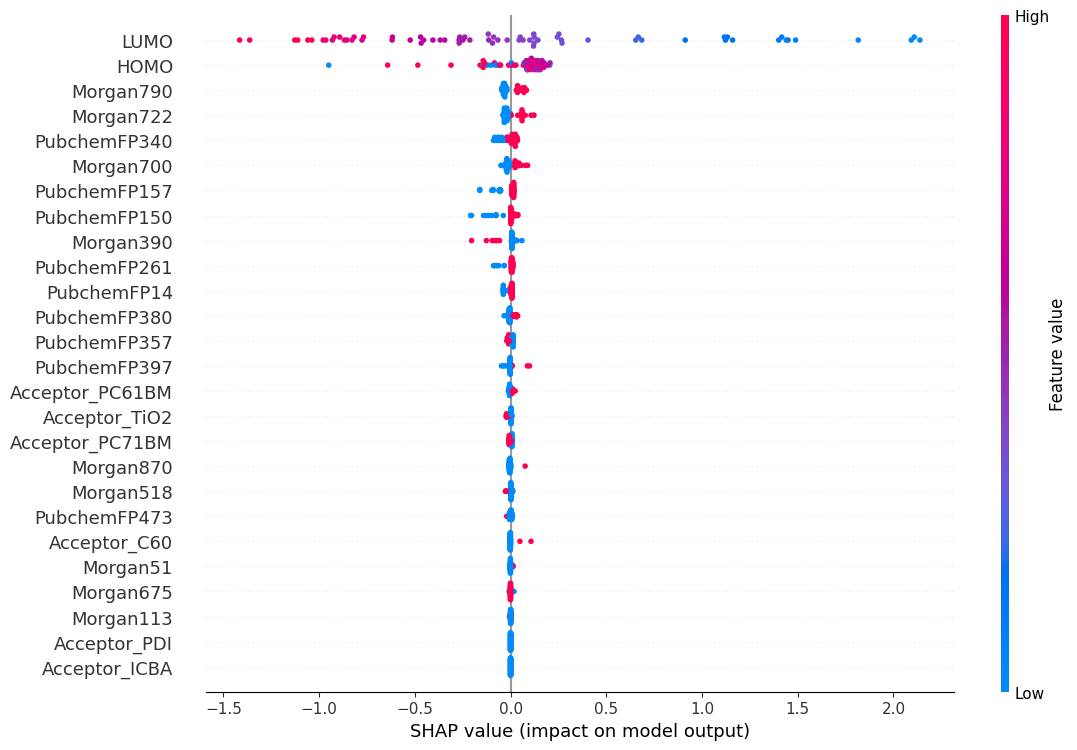

In [ ]:
import shap
# Extract feature names from the test set
feature_names_LUMO_HOMO_reduced_features_encoded = x_LUMO_HOMO_reduced_features_encoded.columns.tolist()

# Convert scaled test set to DataFrame with proper column names
x_test_scaled_df = pd.DataFrame(
    x_test_scaled_LUMO_HOMO_reduced_features_encoded,
    columns=feature_names_LUMO_HOMO_reduced_features_encoded
)

# Initialize SHAP
shap.initjs()

# Create SHAP explainer and compute SHAP values
explainer = shap.Explainer(best_model_LUMO_HOMO_reduced_features_encoded)
shap_values = explainer.shap_values(x_test_scaled_df)

# Set global font sizes for plots
plt.rc('axes', titlesize=20)   # Title size
plt.rc('axes', labelsize=16)   # Axis label size
plt.rc('xtick', labelsize=14)  # X-axis tick size
plt.rc('ytick', labelsize=16)  # Y-axis tick size
plt.rc('legend', fontsize=19)  # Legend font size

# Generate SHAP summary plot
plt.figure(figsize=(14, 10))
shap.summary_plot(
    shap_values,
    x_test_scaled_df,
    max_display=26,
    plot_size=(12, 8),
    show=False
)


['Morgan722', 'Morgan790', 'Morgan700', 'Morgan518', 'Morgan870', 'Morgan390', 'Morgan51', 'Morgan675', 'Morgan113', 'PubchemFP340', 'PubchemFP14', 'PubchemFP150', 'PubchemFP157', 'PubchemFP357', 'PubchemFP473', 'PubchemFP261', 'PubchemFP397', 'PubchemFP380', 'PCE', 'HOMO', 'LUMO', 'Acceptor_C60', 'Acceptor_ICBA', 'Acceptor_PC61BM', 'Acceptor_PC71BM', 'Acceptor_PDI', 'Acceptor_TiO2']


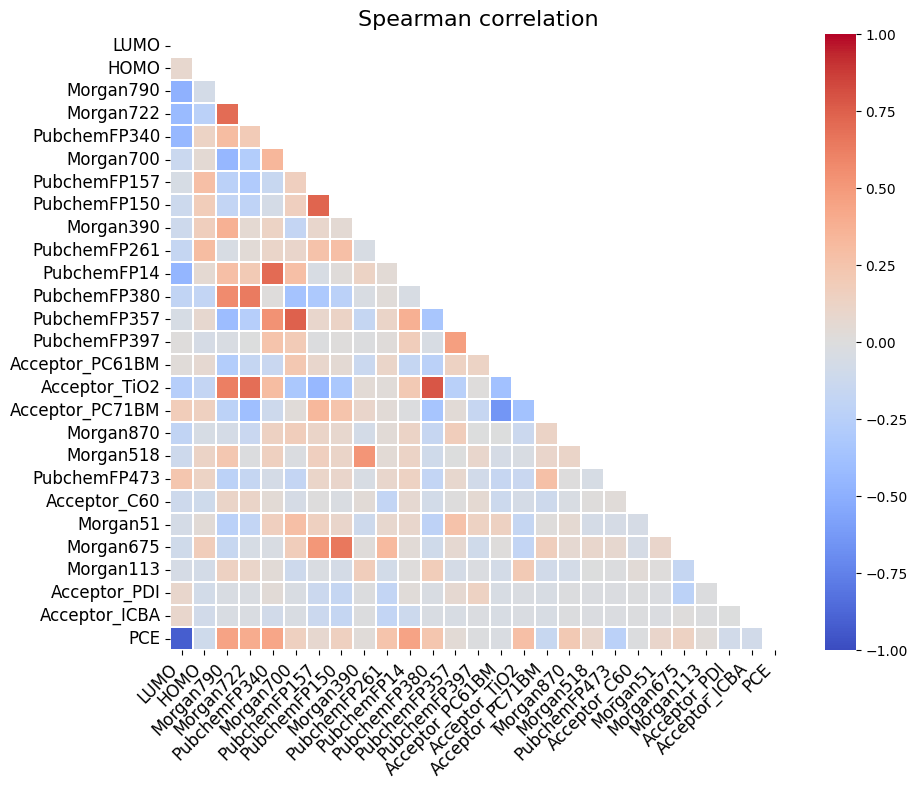

     Feature_1      Feature_2  spearman_corr_values_Correlation
0         HOMO           LUMO                          0.082043
1    Morgan790           LUMO                         -0.486662
2    Morgan790           HOMO                         -0.076775
3    Morgan722           LUMO                         -0.424959
4    Morgan722           HOMO                         -0.233497
..         ...            ...                               ...
346        PCE       Morgan51                          0.097291
347        PCE      Morgan675                          0.138542
348        PCE      Morgan113                          0.029948
349        PCE   Acceptor_PDI                         -0.091877
350        PCE  Acceptor_ICBA                         -0.091877

[351 rows x 3 columns]


In [ ]:
# This spearman corelation includes all 25 features used to train the model 

# Extract column names as a list
feature_name = df_LUMO_HOMO_reduced_features_encoded.columns.to_list()

#Append "Morgan" in front of the initial 9 feature names
# for i in range(9):
#     feature_name[i] = f"Morgan{feature_name[i]}"

# Assign the updated column names back to the DataFrame
df_LUMO_HOMO_reduced_features_encoded.columns = feature_name

# Verify the updated column names
print(df_LUMO_HOMO_reduced_features_encoded.columns.to_list())
data_new = df_LUMO_HOMO_reduced_features_encoded
# Rename specific columns
data_new = data_new.rename(columns={"790": "Morgan790", "722": "Morgan722","700":"Morgan700","390":"Morgan390","870":"Morgan870","518":"Morgan518","51":"Morgan51","675":"Morgan675","113":"Morgan113"})
            
selected_columns = [
    'LUMO',
    'HOMO',
    'Morgan790',
    'Morgan722', 
    'PubchemFP340', 
    'Morgan700',
    'PubchemFP157',
    'PubchemFP150',
    'Morgan390', 
    'PubchemFP261', 
    'PubchemFP14',
    'PubchemFP380',
    'PubchemFP357',
    'PubchemFP397',  
    'Acceptor_PC61BM',
    'Acceptor_TiO2',
    'Acceptor_PC71BM',
    'Morgan870',
    'Morgan518', 
    'PubchemFP473',
    'Acceptor_C60',
    'Morgan51', 
    'Morgan675', 
    'Morgan113', 
    'Acceptor_PDI', 
    'Acceptor_ICBA', 
    'PCE'
]
data_new=data_new[selected_columns]
correlation_matrix_new = data_new.corr(method='spearman')

# Creating a lower triangle mask to filter the correlation matrix
lower_triangle_mask = np.tril(np.ones(correlation_matrix_new.shape), k=-1).astype(bool)
lower_triangle_corr = correlation_matrix_new.where(lower_triangle_mask)
# Plot the lower triangle Spearman correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(lower_triangle_corr, annot=False, cmap='coolwarm', cbar=True, square=True,
            vmin=-1, vmax=1, linewidths=0.2, mask=~lower_triangle_mask)
plt.title('Spearman correlation', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()
# Extracting the correlation values from the lower triangle
spearman_corr_values_corr_values_new = lower_triangle_corr.stack().reset_index()
spearman_corr_values_corr_values_new.columns = ['Feature_1', 'Feature_2', 'spearman_corr_values_Correlation']

# Save to a CSV file or print the values directly
spearman_corr_values_corr_values_new.to_csv("/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/spearman_corr_values_corr_values_25features.csv", index=False)
print(spearman_corr_values_corr_values_new)

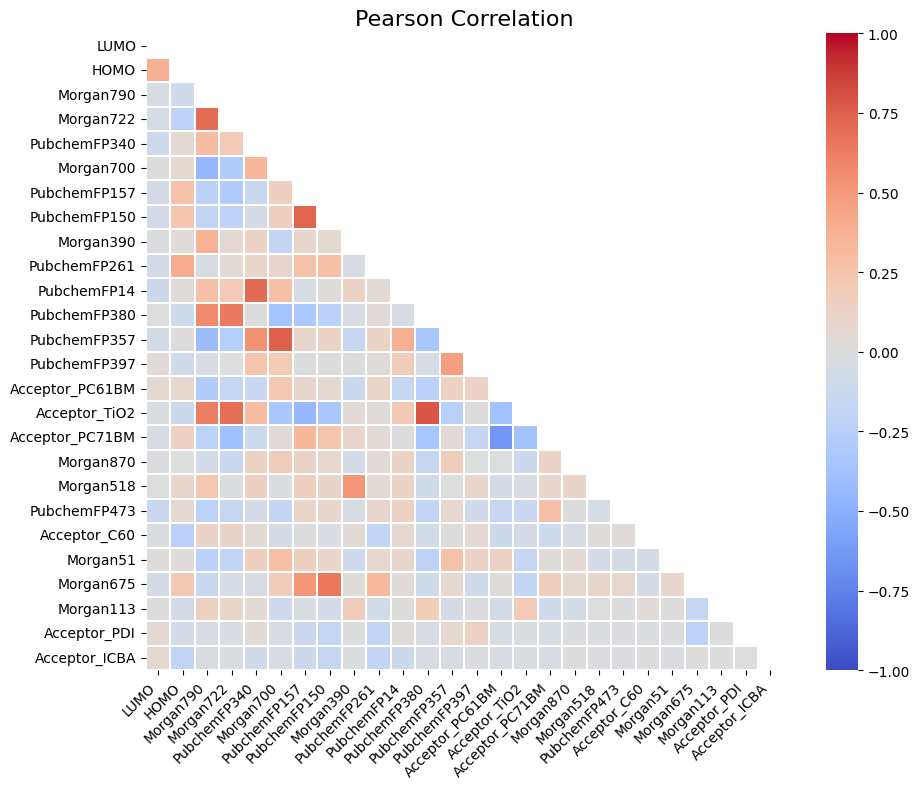

         Feature_1     Feature_2  Pearson_Correlation
0             HOMO          LUMO             0.375787
1        Morgan790          LUMO            -0.053625
2        Morgan790          HOMO            -0.097168
3        Morgan722          LUMO            -0.054437
4        Morgan722          HOMO            -0.210478
..             ...           ...                  ...
320  Acceptor_ICBA  Acceptor_C60            -0.007828
321  Acceptor_ICBA      Morgan51            -0.021615
322  Acceptor_ICBA     Morgan675             0.013134
323  Acceptor_ICBA     Morgan113            -0.015533
324  Acceptor_ICBA  Acceptor_PDI            -0.002933

[325 rows x 3 columns]


In [62]:
# check the Pearson correlation among all features
# Extract column names as a list
feature_name = df_LUMO_HOMO_reduced_features_encoded.columns.to_list()

# Assign the updated column names back to the DataFrame
df_LUMO_HOMO_reduced_features_encoded.columns = feature_name

# Rename specific columns
df_LUMO_HOMO_reduced_features_encoded = df_LUMO_HOMO_reduced_features_encoded.rename(columns={
    "790": "Morgan790", "722": "Morgan722", "700": "Morgan700", "390": "Morgan390", "870": "Morgan870",
    "518": "Morgan518", "51": "Morgan51", "675": "Morgan675", "113": "Morgan113"
})

# Define selected columns excluding PCE
selected_columns = [
    'LUMO', 'HOMO', 'Morgan790', 'Morgan722', 'PubchemFP340', 'Morgan700',
    'PubchemFP157', 'PubchemFP150', 'Morgan390', 'PubchemFP261', 'PubchemFP14',
    'PubchemFP380', 'PubchemFP357', 'PubchemFP397', 'Acceptor_PC61BM', 'Acceptor_TiO2',
    'Acceptor_PC71BM', 'Morgan870', 'Morgan518', 'PubchemFP473', 'Acceptor_C60',
    'Morgan51', 'Morgan675', 'Morgan113', 'Acceptor_PDI', 'Acceptor_ICBA'
]

data_new = df_LUMO_HOMO_reduced_features_encoded[selected_columns]

# Compute Pearson correlation matrix
correlation_matrix_new = data_new.corr(method='pearson')

# Create a lower triangle mask
lower_triangle_mask = np.tril(np.ones(correlation_matrix_new.shape), k=-1).astype(bool)
lower_triangle_corr = correlation_matrix_new.where(lower_triangle_mask)

# Plot the lower triangle Pearson correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(lower_triangle_corr, annot=False, cmap='coolwarm', cbar=True, square=True,
            vmin=-1, vmax=1, linewidths=0.2, mask=~lower_triangle_mask)
plt.title('Pearson Correlation',fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.tight_layout()
plt.show()

# Extract lower triangle correlation values
pearson_corr_values = lower_triangle_corr.stack().reset_index()
pearson_corr_values.columns = ['Feature_1', 'Feature_2', 'Pearson_Correlation']

# Save to CSV
pearson_corr_values.to_csv("/home/yxy220016/OPV project/Random Forest/Data/Data_processed/HOPV15_new/pearson_corr_values_25features.csv", index=False)
print(pearson_corr_values) 

                 Interaction_with_HOMO
HOMO                          0.029858
LUMO                          0.007443
Morgan390                     0.001312
PubchemFP397                  0.000614
Morgan722                     0.000558
Morgan700                     0.000545
PubchemFP340                  0.000180
Acceptor_PC71BM               0.000116
Morgan518                     0.000064
Acceptor_PC61BM               0.000052
Morgan51                      0.000043
Acceptor_C60                  0.000035
Acceptor_PDI                  0.000000
Acceptor_ICBA                 0.000000
Morgan870                    -0.000010
Morgan113                    -0.000036
PubchemFP380                 -0.000047
PubchemFP357                 -0.000049
Acceptor_TiO2                -0.000227
Morgan675                    -0.000262
PubchemFP473                 -0.000317
PubchemFP157                 -0.000415
Morgan790                    -0.000603
PubchemFP14                  -0.000607
PubchemFP261             

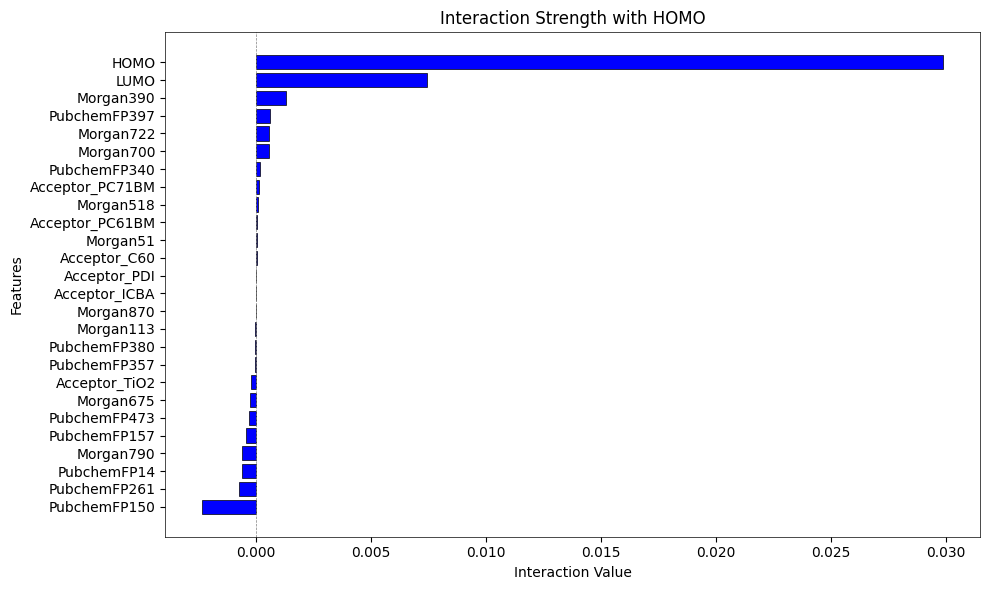

In [ ]:
# find the correlated features with HOMO using SHAP
# Compute SHAP interaction values
interaction_values = shap.TreeExplainer(best_model_LUMO_HOMO_reduced_features_encoded).shap_interaction_values(x_test_scaled_LUMO_HOMO_reduced_features_encoded)

# Extract interaction values for HOMO
x_test_scaled_LUMO_HOMO_reduced_features_encoded, y_test_LUMO_HOMO_reduced_features_encoded, test_predictions_LUMO_HOMO_reduced_features_encoded, scaler_LUMO_HOMO_reduced_features_encoded, test_indices_LUMO_HOMO_reduced_features_encoded, difficult_points_LUMO_HOMO_reduced_features_encoded, best_model_LUMO_HOMO_reduced_features_encoded =main_loop_with_stratified_cv(x_LUMO_HOMO_reduced_features_encoded,y_LUMO_HOMO_encoded)
homo_index = x_test_scaled_LUMO_HOMO_reduced_features_encoded.columns.get_loc("HOMO")
homo_interactions = interaction_values[:, homo_index, :]

# Create a DataFrame to summarize HOMO interactions with all other features
interaction_df = pd.DataFrame(homo_interactions.mean(axis=0), index=x_test_scaled_LUMO_HOMO_reduced_features_encoded.columns, columns=["Interaction_with_HOMO"])

# Sort by interaction strength
interaction_df_sorted = interaction_df.sort_values(by="Interaction_with_HOMO", ascending=False)

# Display the sorted interaction values
print(interaction_df_sorted)
import matplotlib.pyplot as plt

# Data for the bar plot (interaction values)
interaction_with_homo = {
    "HOMO": 0.029858,
    "LUMO": 0.007443,
    "Morgan390": 0.001312,
    "PubchemFP397": 0.000614,
    "Morgan722": 0.000558,
    "Morgan700": 0.000545,
    "PubchemFP340": 0.000180,
    "Acceptor_PC71BM": 0.000116,
    "Morgan518": 0.000064,
    "Acceptor_PC61BM": 0.000052,
    "Morgan51": 0.000043,
    "Acceptor_C60": 0.000035,
    "Acceptor_PDI": 0.000000,
    "Acceptor_ICBA": 0.000000,
    "Morgan870": -0.000010,
    "Morgan113": -0.000036,
    "PubchemFP380": -0.000047,
    "PubchemFP357": -0.000049,
    "Acceptor_TiO2": -0.000227,
    "Morgan675": -0.000262,
    "PubchemFP473": -0.000317,
    "PubchemFP157": -0.000415,
    "Morgan790": -0.000603,
    "PubchemFP14": -0.000607,
    "PubchemFP261": -0.000744,
    "PubchemFP150": -0.002330,
}

# Convert data to a sorted list of tuples
interaction_sorted = sorted(interaction_with_homo.items(), key=lambda x: x[1], reverse=True)

# Unpack keys and values for plotting
features, values = zip(*interaction_sorted)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, values, color="blue", edgecolor="black", linewidth=0.5)  # Subtle bar borders
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')  # Add a vertical line at 0 for reference
plt.title("Interaction Strength with HOMO")
plt.xlabel("Interaction Value")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values on top

# Customize the outer border (spines)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set to a less noticeable color
    spine.set_linewidth(0.5)  # Reduce the thickness of the border

plt.tight_layout()
plt.show()


In SHAP, the interaction value of HOMO with itself measures its main effect—the contribution of HOMO to the model’s predictions when considered independently of other features.
A high interaction value for HOMO with itself suggests that HOMO is being heavily utilized by the model for making predictions.
This does not mean HOMO alone can explain PCE variations in the raw data. Instead, it reflects that the model has learned to use HOMO in ways that may involve complex, non-linear relationships and interactions with other features.
High SHAP but low Spearman correlation for HOMO suggests:
A non-monotonic relationship between HOMO and PCE.
HOMO's importance in PCE prediction is interaction-dependent.

                 Interaction_with_LUMO
LUMO                      1.943826e-02
HOMO                      7.443149e-03
PubchemFP340              1.473892e-03
PubchemFP473              9.599775e-04
Morgan790                 4.754963e-04
PubchemFP150              4.247924e-04
Acceptor_PC71BM           4.228969e-04
PubchemFP357              4.020429e-04
Morgan675                 2.660023e-04
Morgan390                 2.320166e-04
Acceptor_PC61BM           1.787371e-04
Morgan870                 1.583961e-04
PubchemFP380              1.464770e-04
Morgan51                  6.312740e-05
Morgan113                 5.737356e-05
Acceptor_TiO2             3.137623e-05
Acceptor_C60              1.715677e-05
Morgan518                 9.553700e-07
Acceptor_ICBA             0.000000e+00
Acceptor_PDI              0.000000e+00
PubchemFP261             -1.092229e-06
PubchemFP157             -1.294850e-05
PubchemFP14              -5.729832e-05
PubchemFP397             -1.507861e-04
Morgan700                

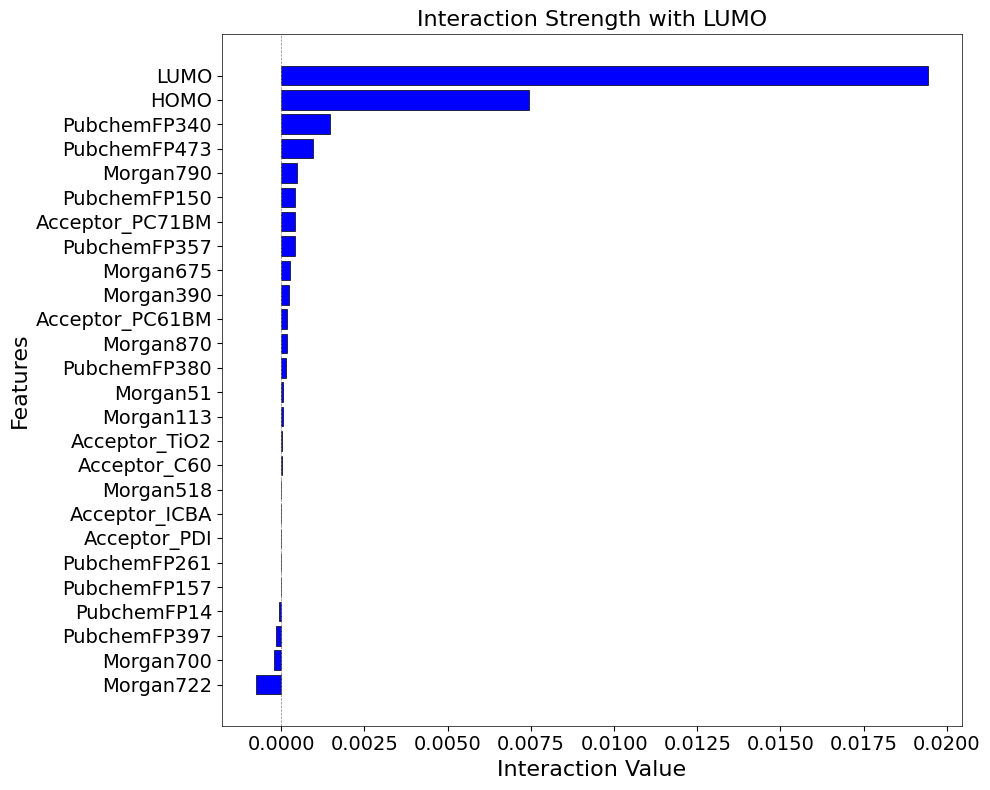

In [ ]:
# find the correlated features with LUMO using SHAP
# Compute SHAP interaction values
import shap
interaction_values = shap.TreeExplainer(best_model_LUMO_HOMO_reduced_features_encoded).shap_interaction_values(x_test_scaled_LUMO_HOMO_reduced_features_encoded)

# Extract interaction values for HOMO
homo_index = x_test_scaled_LUMO_HOMO_reduced_features_encoded.columns.get_loc("LUMO")
homo_interactions = interaction_values[:, homo_index, :]

# Create a DataFrame to summarize HOMO interactions with all other features
interaction_df = pd.DataFrame(homo_interactions.mean(axis=0), index=x_test_scaled_LUMO_HOMO_reduced_features_encoded.columns, columns=["Interaction_with_LUMO"])

# Sort by interaction strength
interaction_df_sorted = interaction_df.sort_values(by="Interaction_with_LUMO", ascending=False)

# Display the sorted interaction values
print(interaction_df_sorted)
import matplotlib.pyplot as plt

# Data for the bar plot (interaction values)
# Creating the dictionary for interaction with LUMO
interaction_with_lumo = {
    "LUMO": 1.943826e-02,
    "HOMO": 7.443149e-03,
    "PubchemFP340": 1.473892e-03,
    "PubchemFP473": 9.599775e-04,
    "Morgan790": 4.754963e-04,
    "PubchemFP150": 4.247924e-04,
    "Acceptor_PC71BM": 4.228969e-04,
    "PubchemFP357": 4.020429e-04,
    "Morgan675": 2.660023e-04,
    "Morgan390": 2.320166e-04,
    "Acceptor_PC61BM": 1.787371e-04,
    "Morgan870": 1.583961e-04,
    "PubchemFP380": 1.464770e-04,
    "Morgan51": 6.312740e-05,
    "Morgan113": 5.737356e-05,
    "Acceptor_TiO2": 3.137623e-05,
    "Acceptor_C60": 1.715677e-05,
    "Morgan518": 9.553700e-07,
    "Acceptor_ICBA": 0.000000e+00,
    "Acceptor_PDI": 0.000000e+00,
    "PubchemFP261": -1.092229e-06,
    "PubchemFP157": -1.294850e-05,
    "PubchemFP14": -5.729832e-05,
    "PubchemFP397": -1.507861e-04,
    "Morgan700": -2.075336e-04,
    "Morgan722": -7.730072e-04
}



# Convert data to a sorted list of tuples
interaction_sorted = sorted(interaction_with_lumo.items(), key=lambda x: x[1], reverse=True)

# Unpack keys and values for plotting
features, values = zip(*interaction_sorted)

# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(features, values, color="blue", edgecolor="black", linewidth=0.5)  # Subtle bar borders
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')  # Add a vertical line at 0 for reference
plt.title("Interaction Strength with LUMO", fontsize=16)
plt.xlabel("Interaction Value",fontsize=16)
plt.ylabel("Features",fontsize=16)
plt.xticks(fontsize=14)  # Increase x-axis tick labels
plt.yticks(fontsize=14) 
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values on top

# Customize the outer border (spines)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set to a less noticeable color
    spine.set_linewidth(0.5)  # Reduce the thickness of the border

plt.tight_layout()
plt.show()



### Validate the presence of features identified by SHAP in high-/low- performing molecules 





In [ ]:
# step 1, divide COMPUTED pce into high, medium and low value intervals 
# step 2, retrieve their SMILES
df_original 
print(df_LUMO_HOMO_reduced_features_encoded.shape)
df_selec=pd.concat([df_original['SMILES'],df_LUMO_HOMO_reduced_features_encoded],axis=1)
print(df_selec.columns)
df_selec.rename(columns={'722':'Morgan722', '790':'Morgan790', '700':'Morgan700', '518':'Morgan518', '870':'Morgan870', '390':'Morgan390','51':'Morgan51', '675':'Morgan675', '113':'Morgan113'},inplace=True)
df_selec['PCE_interval'] = pd.qcut(df_selec['PCE'], q=5,labels = ['Very Low','Low', 'Medium', 'High','Very High'])
print(df_selec.head(1))
# step 3: output the donors either with high PCE or low PCE
df_low_pce = df_selec[df_selec['PCE_interval']== 'Very Low']
df_high_pce = df_selec[df_selec['PCE_interval']== 'Very High']
print(df_low_pce.shape)
print(df_high_pce.columns)


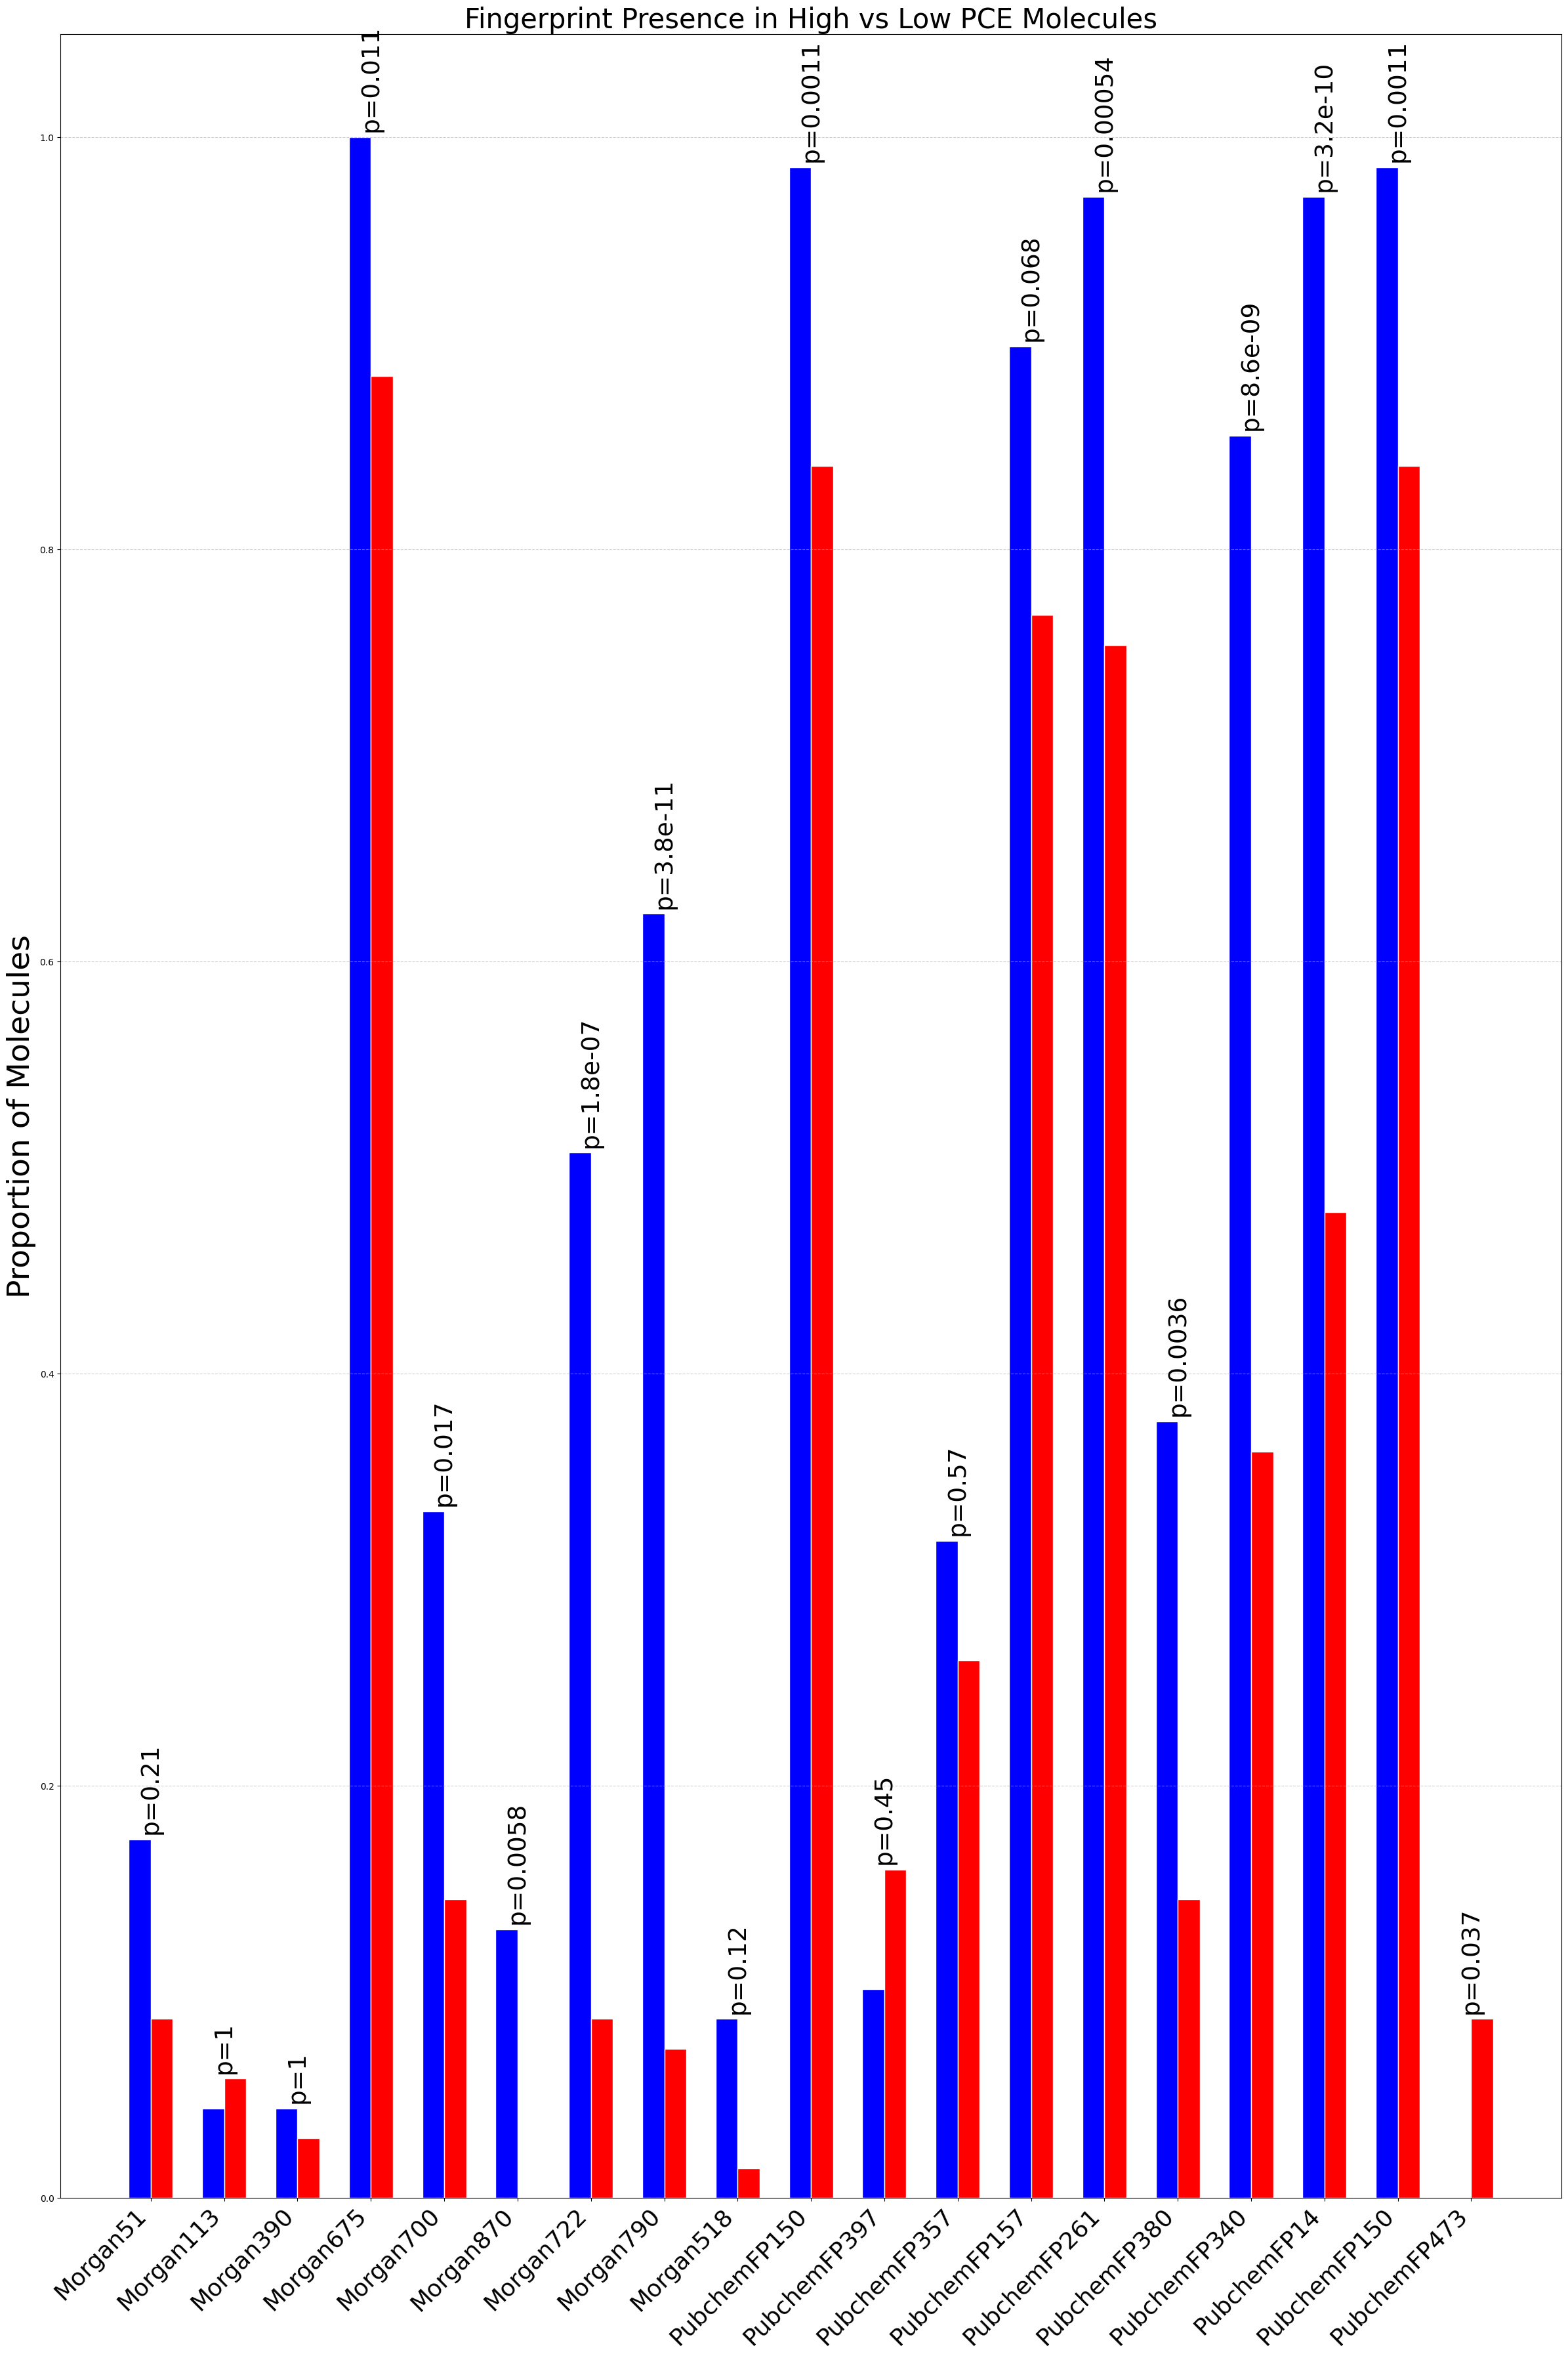

In [40]:
# step 4: identify the presence of these features among these molecules 
from scipy.stats import chi2_contingency
#features of interest 
selected_features = ['Morgan51','Morgan113','Morgan390','Morgan675','Morgan700','Morgan870','Morgan722','Morgan790','Morgan518','PubchemFP150','PubchemFP397','PubchemFP357','PubchemFP157','PubchemFP261','PubchemFP380','PubchemFP340','PubchemFP14','PubchemFP150','PubchemFP473']
# Subset features and presence counts
high_pce_features = df_high_pce[selected_features].sum()
low_pce_features = df_low_pce[selected_features].sum()
# Frequency proportion
high_pce_proportion = high_pce_features / len(df_high_pce)
low_pce_proportion = low_pce_features / len(df_low_pce)

# Combine results into a DataFrame
feature_analysis = pd.DataFrame({
    'Feature': selected_features,
    'High_PCE_Frequency': high_pce_features.values,
    'High_PCE_Proportion': high_pce_proportion.values,
    'Low_PCE_Frequency': low_pce_features.values,
    'Low_PCE_Proportion': low_pce_proportion.values
})




# Perform a Chi-square test for each feature
feature_analysis['P_Value'] = [
    chi2_contingency([
        [high_pce_features[feature], len(df_high_pce) - high_pce_features[feature]],
        [low_pce_features[feature], len(df_low_pce) - low_pce_features[feature]]
    ])[1] for feature in selected_features
]


# Add p-values to the bar plot
fig, ax = plt.subplots(figsize=(24, 36))
bar_width = 0.3
x = range(len(selected_features))

# Bar plot
ax.bar([i - bar_width/2 for i in x], feature_analysis['High_PCE_Proportion'], 
       bar_width, label='High PCE Proportion', color='blue', edgecolor='white')
ax.bar([i + bar_width/2 for i in x], feature_analysis['Low_PCE_Proportion'], 
       bar_width, label='Low PCE Proportion', color='red', edgecolor='white')

# Adding p-values above the bars
for i, (feature, p_value) in enumerate(zip(feature_analysis['Feature'], feature_analysis['P_Value'])):
    ax.text(i, max(feature_analysis['High_PCE_Proportion'][i], feature_analysis['Low_PCE_Proportion'][i])+0.005, 
            f'p={p_value:.2g}', ha='center', fontsize=27, rotation=90,color='black')

# Improve aesthetics
ax.set_title('Fingerprint Presence in High vs Low PCE Molecules', fontsize=30)
ax.set_ylabel('Proportion of Molecules', fontsize=34)
# ax.set_xlabel('Fingerprint', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(selected_features, rotation=45, ha='right', fontsize=26)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


The p-value in this context is derived from the Chi-square test for independence.
The p-value in the chart reflects whether the difference between High and Low PCE proportions for a specific fingerprint is statistically significant.p value < 0.05 is considered of being significantly corelated with target value